In [ ]:
#!pip install catboost

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder,PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import spearmanr
from scipy.sparse import hstack
from sklearn.impute import KNNImputer
import tensorflow as tf

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **Generate EDA using ydata_profiling**

In [227]:
# !pip install ydata-profiling
# from ydata_profiling import ProfileReport
# profile = ProfileReport(df, title="GuestSatisfactionPredictionEDA", explorative=True)
# # Display in Jupyter notebook
# profile.to_notebook_iframe()
# # Save EDA as HTML
# profile.to_file("GuestSatisfactionPredictionEDA.html")

# **Basic Cleaning**

In [228]:
df = pd.read_csv("GuestSatisfactionPrediction.csv")
df.head()

<ipython-input-228-f41ae7a1ecf1>:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("GuestSatisfactionPrediction.csv")


,id,listing_url,name,summary,space,description,neighborhood_overview,notes,transit,access,...,number_of_stays,first_review,last_review,review_scores_rating,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,21514496,https://www.airbnb.com/rooms/21514496,PRIVATE BEDROOM DOWNTOWN 2 BED/ 2 BATH #5,Beautiful 2 bedroom 2 bathroom furnished apart...,Each apartment is fully furnished and consists...,Beautiful 2 bedroom 2 bathroom furnished apart...,NaN,***Note that the pictures on the website may o...,NaN,NaN,...,2,11/17/2017,11/17/2017,80.0,f,f,f,strict_14_with_grace_period,f,f
1,990185,https://www.airbnb.com/rooms/990185,4 bed/2 ba Family Retreat in SD,We feel our house is a great place for a famil...,Our house is ideal for large families or group...,We feel our house is a great place for a famil...,Neighborhood Mira Mesa is a culturally diverse...,NaN,NaN,Our guests may use the BBQ grill.,...,26,8/2/2013,7/31/2019,97.0,f,f,f,moderate,f,f
2,19878244,https://www.airbnb.com/rooms/19878244,San Diego Dream Villa,"Zen, Luxury and the Best Location in Americas ...","San Diego Dream Villa, this unique and luxurio...","Zen, Luxury and the Best Location in Americas ...",This amazing house is located within a few min...,Im always available to make your trip experien...,"If you are bringing your car, remember that SD...",A couple of days before your arrival you will ...,...,170,7/23/2017,7/16/2019,98.0,f,f,f,strict_14_with_grace_period,f,f
3,24561458,https://www.airbnb.com/rooms/24561458,Studio with Piazza View in Downtown Little Italy,Start the day with breakfast on the sunny pati...,"Newly built, this beautiful studio is located ...",Start the day with breakfast on the sunny pati...,"Spend the day at the zoo in Balboa Park, or ex...",The apartment is located on the Piazza Della F...,"MTS, Train, and Trolly are close by. The airpo...",You will not be sharing the apartment with any...,...,212,5/1/2018,8/3/2019,98.0,f,t,f,moderate,f,f
4,32269829,https://www.airbnb.com/rooms/32269829,Beachside Retreat w/ Private Rooftop Deck w/ V...,This is a 2 bedroom/1 bathroom beachside unit...,Beach living at its finest! The highlight of ...,This is a 2 bedroom/1 bathroom beachside unit...,Mission Beach is an amazing coastal community ...,NaN,The Boardwalk and Bayside Walk are wonderful w...,This is a private home that is part of a typic...,...,2,6/30/2019,6/30/2019,100.0,f,t,f,strict_14_with_grace_period,f,f


**INITAL** **DROPS**

In [229]:
drop_columns = ['thumbnail_url', 'host_acceptance_rate','square_feet','is_business_travel_ready','requires_license','id','country_code','summary',
                'host_url','listing_url','name','neighbourhood','street','host_has_profile_pic','country','smart_location','market','state','city',
                'bed_type','require_guest_phone_verification','require_guest_profile_picture', 'host_name', 'space','host_total_listings_count',
                'latitude', 'longitude']
df.drop(columns=drop_columns, inplace=True)

Y = df['review_scores_rating']

**Neseccsary Convergances**

In [230]:
df['extra_people'] = df['extra_people'].replace(r'[\$,]', '', regex=True).astype(float)
df['nightly_price'] = df['nightly_price'].replace(r'[\$,]', '', regex=True).astype(float)
df['price_per_stay'] = df['price_per_stay'].replace(r'[\$,]', '', regex=True).astype(float)
df['security_deposit'] = df['security_deposit'].replace(r'[\$,]', '', regex=True).astype(float)
df['cleaning_fee'] = df['cleaning_fee'].replace(r'[\$,]', '', regex=True).astype(float)
df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce')
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')

# **Filling Missing Values**

In [231]:
# Fill text fields with empty string
columns = [ 'description','transit', 'access', 'interaction', 'house_rules']
df[columns] = df[columns].fillna('No information provided')

In [232]:
# Fill categorical with mode
categorical_cols = [ 'host_location','host_is_superhost',
                     'host_identity_verified',]
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [233]:
### --- Fill 'host_neighbourhood' using 'neighbourhood_cleansed' ---
df['host_neighbourhood'] = df.groupby('neighbourhood_cleansed')['host_neighbourhood'] \
    .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['host_neighbourhood'].mode()[0]))

# If still missing, fill with overall mode
df['host_neighbourhood'] = df['host_neighbourhood'].fillna(df['host_neighbourhood'].mode()[0])

### --- Fill 'host_response_time' using 'host_is_superhost' and 'host_response_rate' ---
df['host_response_time'] = df.groupby(['host_is_superhost', 'host_response_rate'])['host_response_time'] \
    .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['host_response_time'].mode()[0]))

# If still missing, fill with overall mode
df['host_response_time'] = df['host_response_time'].fillna(df['host_response_time'].mode()[0])

df['neighborhood_overview'] = df.groupby('neighbourhood_cleansed')['neighborhood_overview'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "No overview available")
)

# If still missing, fill with overall mode
df['neighborhood_overview'] = df['neighborhood_overview'].fillna(df['neighborhood_overview'].mode()[0])

In [234]:
# Fill 'host_about' if missing
df['host_about'] = df.apply(
    lambda row: (
        "is a host offering a {row['room_type']} in {row['neighbourhood_cleansed']}. "
        f"Guests usually enjoy a {row['property_type']} with great hospitality."
        if pd.isnull(row['host_about']) else row['host_about']
    ), axis=1
)

# Fill 'notes' if missing
df['notes'] = df.apply(
    lambda row: (
        f"This {row['room_type']} in {row['neighbourhood_cleansed']} offers a comfortable stay. "
        f"Arrival instructions and local tips will be shared after booking."
        if pd.isnull(row['notes']) else row['notes']
    ), axis=1
)

In [235]:
# Safely strip '%' and convert to float
df['host_response_rate'] = df['host_response_rate'].astype(str).str.rstrip('%')
df['host_response_rate'] = pd.to_numeric(df['host_response_rate'], errors='coerce')
df['host_response_rate'] = df['host_response_rate'].fillna(df['host_response_rate'].median())

In [236]:
# Clean 'zipcode': keep only the first 5 digits
df['zipcode'] = df['zipcode'].astype(str).str.extract(r'(\d{5})')
df['zipcode'] = pd.to_numeric(df['zipcode'], errors='coerce')

# Fill all numeric columns with median
numeric_cols_median = ['zipcode', 'bathrooms', 'bedrooms', 'beds', 'host_listings_count']

for col in numeric_cols_median:
    df[col] = df[col].fillna(df[col].median())

In [237]:
# Optional numeric financials
df['security_deposit'] = df['security_deposit'].fillna(0)
df['cleaning_fee'] = df['cleaning_fee'].fillna(0)

In [238]:
if 'neighbourhood' in df.columns:
    df.drop('neighbourhood', axis=1, inplace=True)


# Build the summary table
summary = pd.DataFrame({
    'Feature': df.columns,
    'Data Type': df.dtypes.values,
    'Missing Values': df.isnull().sum().values
})

# Sort by number of missing values (descending)
summary = summary.sort_values(by='Missing Values', ascending=False).reset_index(drop=True)

# Display all 69 rows
pd.set_option('display.max_rows', None)
print(summary)

                   Feature       Data Type  Missing Values
0               host_since  datetime64[ns]               1
1              description          object               0
2    neighborhood_overview          object               0
3                    notes          object               0
4                   access          object               0
5                  transit          object               0
6              interaction          object               0
7              house_rules          object               0
8                  host_id           int64               0
9            host_location          object               0
10              host_about          object               0
11      host_response_time          object               0
12      host_response_rate         float64               0
13       host_is_superhost          object               0
14      host_neighbourhood          object               0
15     host_listings_count         float64              

# **Some Visualizations**

In [239]:
def get_numeric_columns(df, sample_ratio=0.3):
    numeric_columns = []

    for col in df.columns:
        sample = df[col].dropna().sample(frac=min(sample_ratio, 1.0), random_state=42)

        is_numeric = sample.apply(lambda x: isinstance(x, (int, float))).mean() > 0.8

        if is_numeric:
            numeric_columns.append(col)

    return numeric_columns
def get_categorical_columns(df, sample_ratio=0.3, max_unique=2):
    categorical_columns = []

    for col in df.columns:
        sample = df[col].dropna().sample(frac=min(sample_ratio, 1.0), random_state=42)

        if sample.nunique() <= max_unique:
            categorical_columns.append(col)

    return categorical_columns
Numerical_cols = get_numeric_columns(df)
Categorical_cols = get_categorical_columns(df)
print("Numerical columns:", Numerical_cols)
print('///////////////////////////////////////////////////////////////////')
#Categorical_cols = [ 'is_location_exact', 'host_identity_verified','host_is_superhost','host_response_rate','instant_bookable' ]
print("categorical columns:", Categorical_cols)


Numerical columns: ['host_id', 'host_response_rate', 'host_listings_count', 'zipcode', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'nightly_price', 'price_per_stay', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'number_of_stays', 'review_scores_rating']
///////////////////////////////////////////////////////////////////
categorical columns: ['host_is_superhost', 'host_identity_verified', 'is_location_exact', 'instant_bookable']


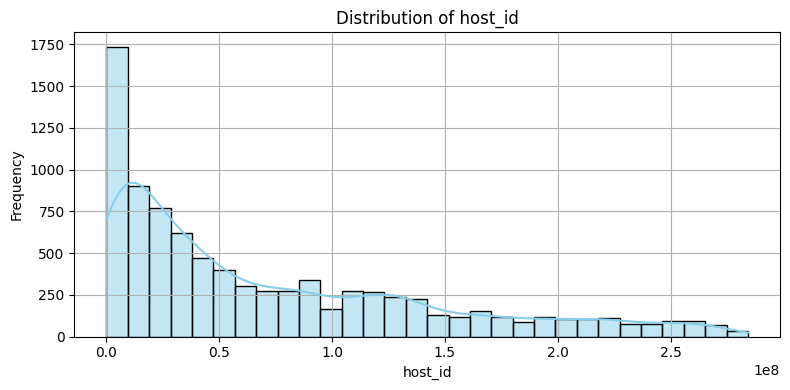

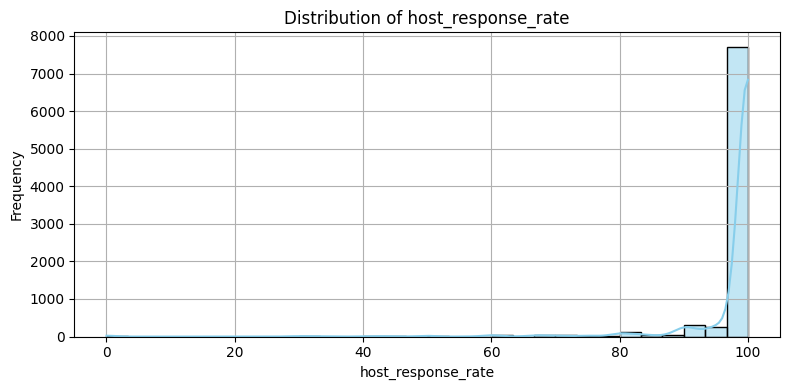

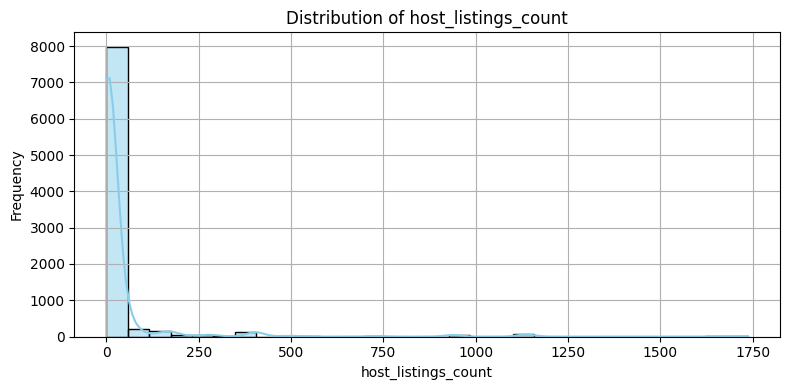

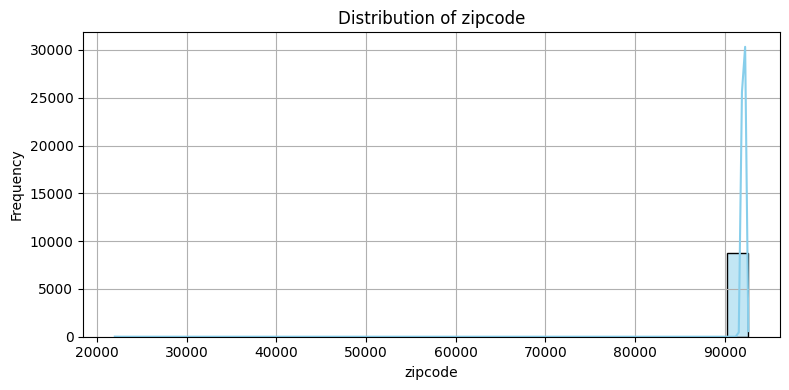

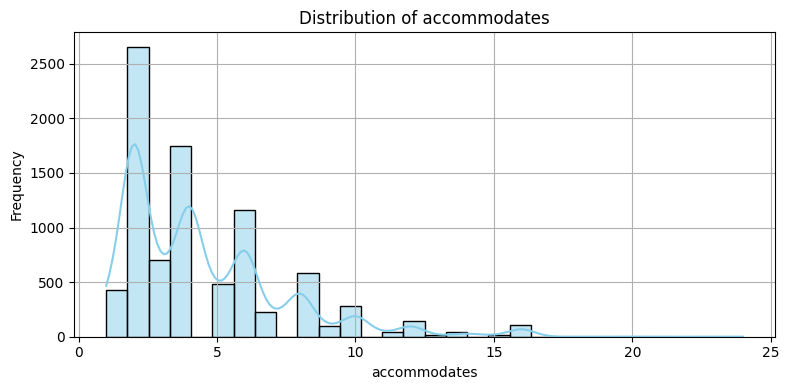

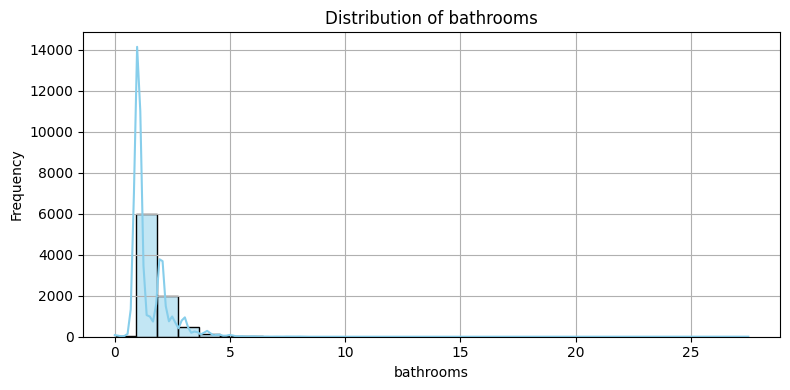

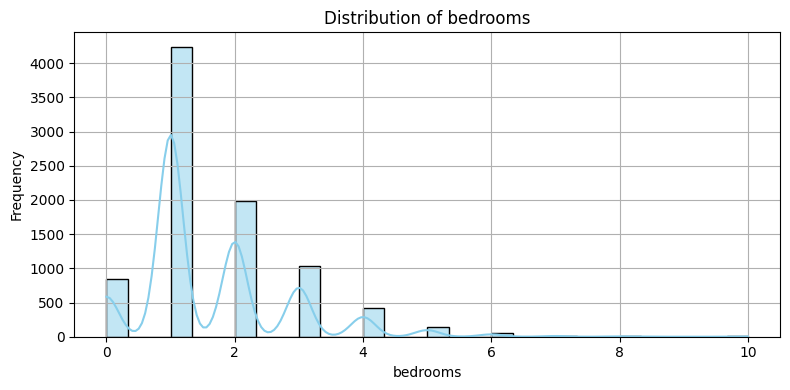

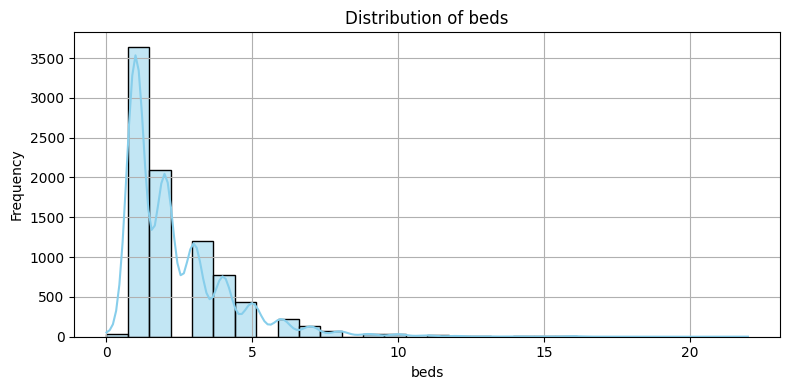

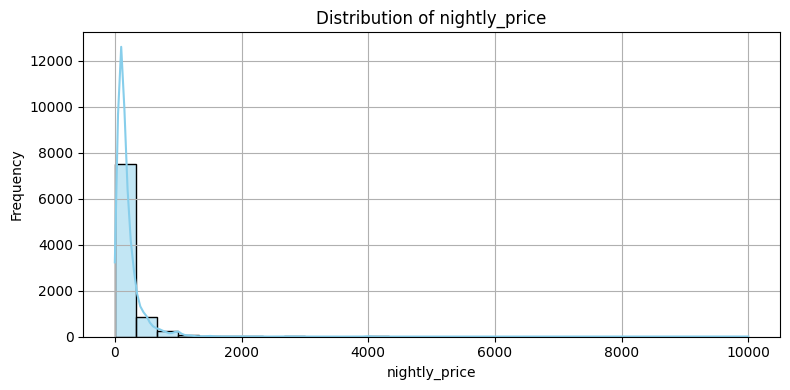

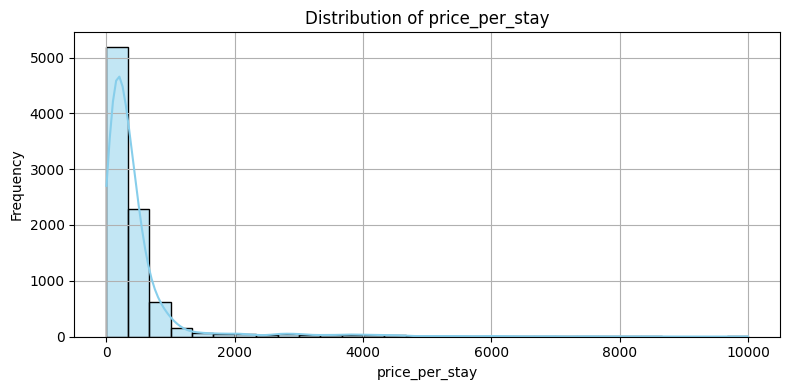

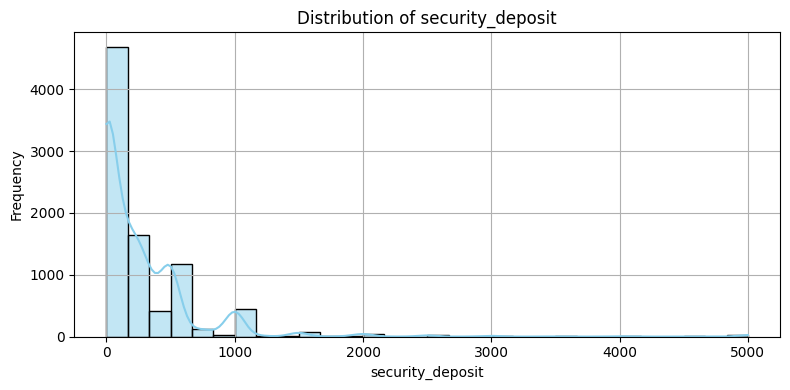

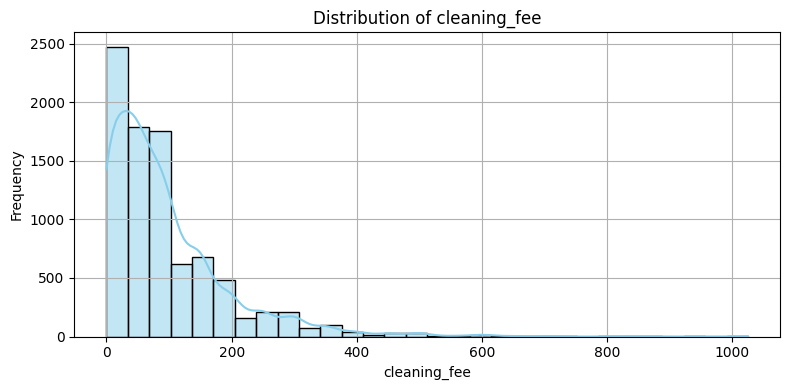

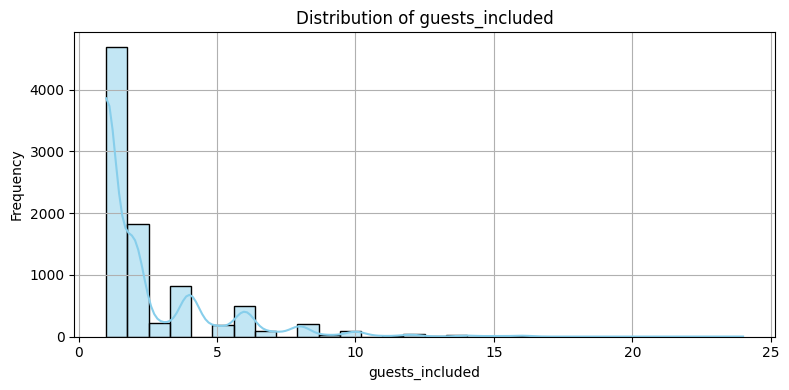

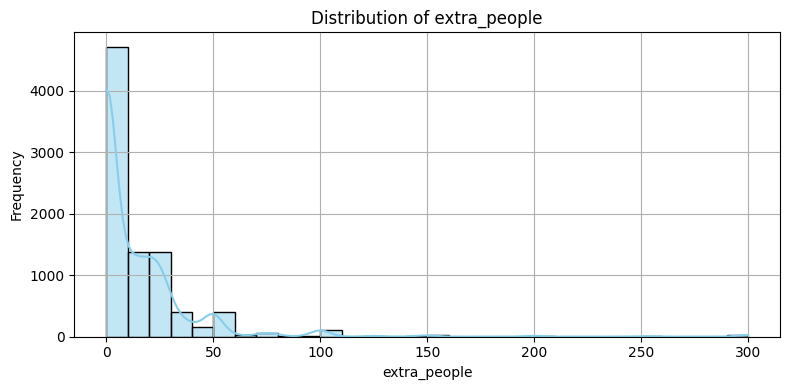

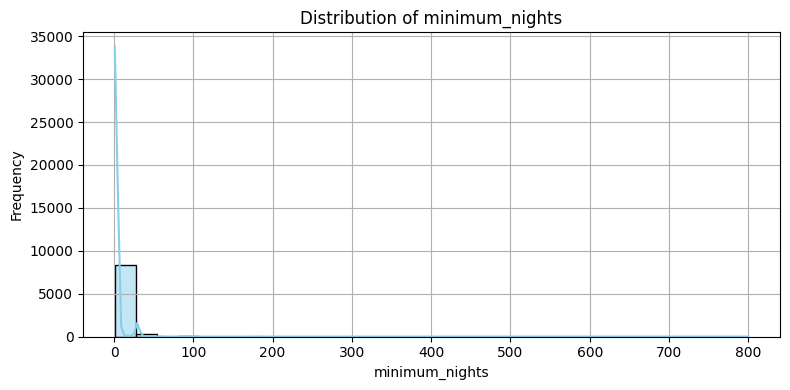

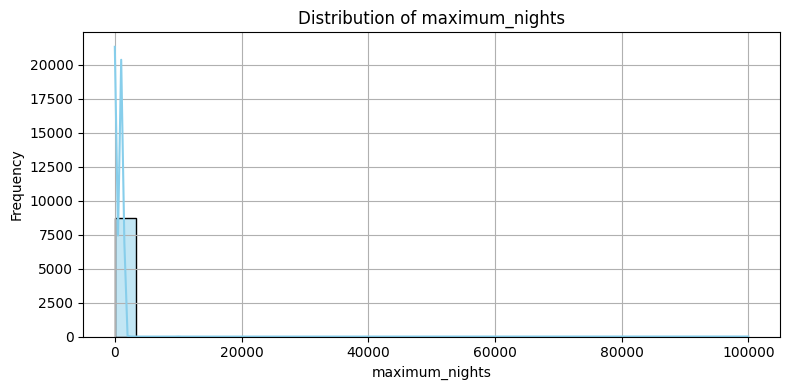

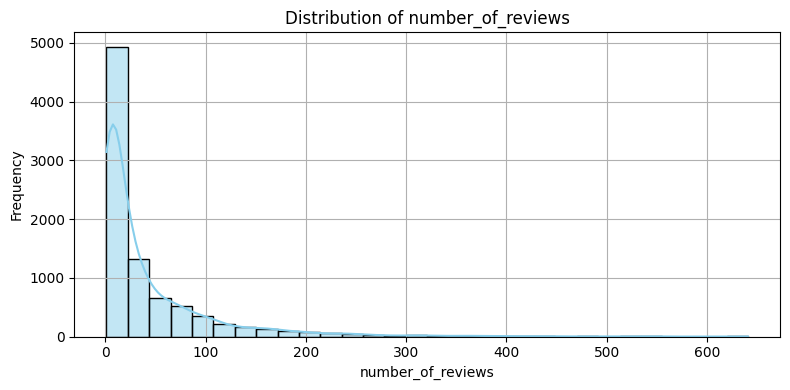

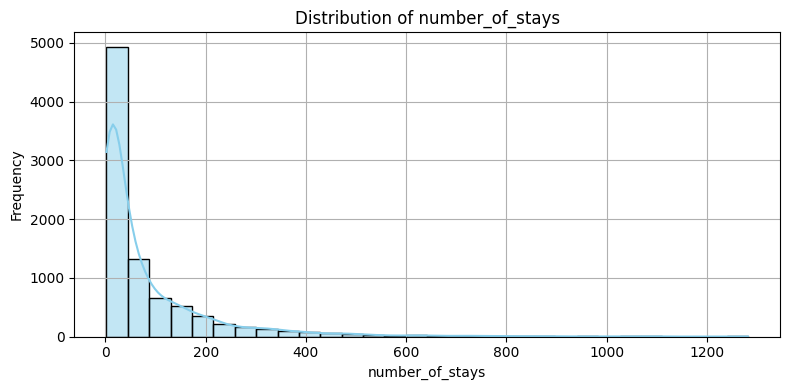

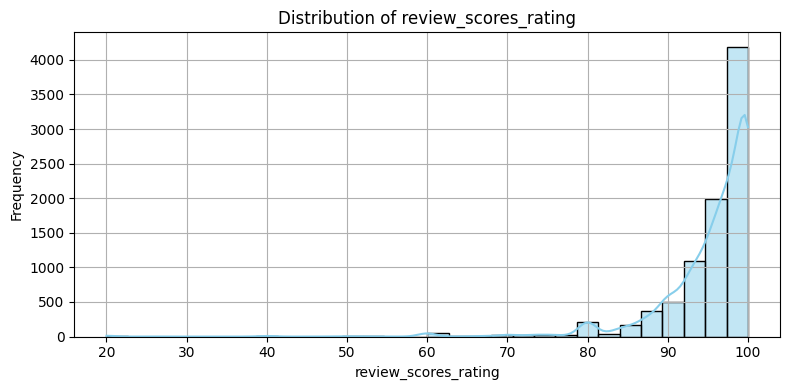

In [240]:
def plot_distributions(df, numerical_cols):
    for col in numerical_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_distributions(df, Numerical_cols)

In [241]:
def plot_distributions(df, numerical_cols):
    for col in numerical_cols:
        if pd.api.types.is_numeric_dtype(df[col]):  # Check if the column is numeric
            plt.figure(figsize=(8, 4))
            sns.histplot(df[col], kde=True, bins=30, color='skyblue')
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Skipping non-numeric column: {col}")

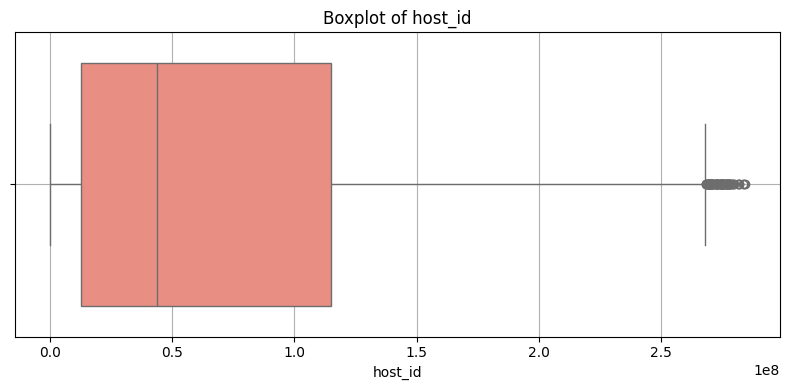

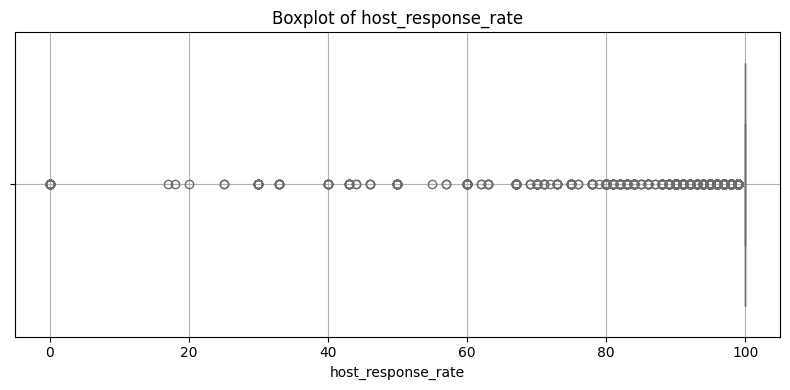

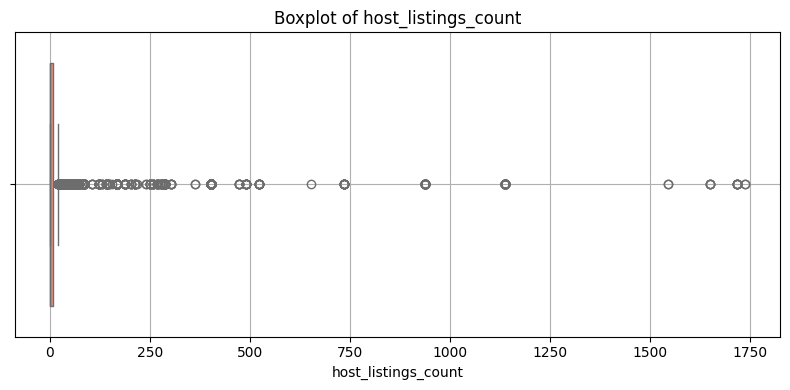

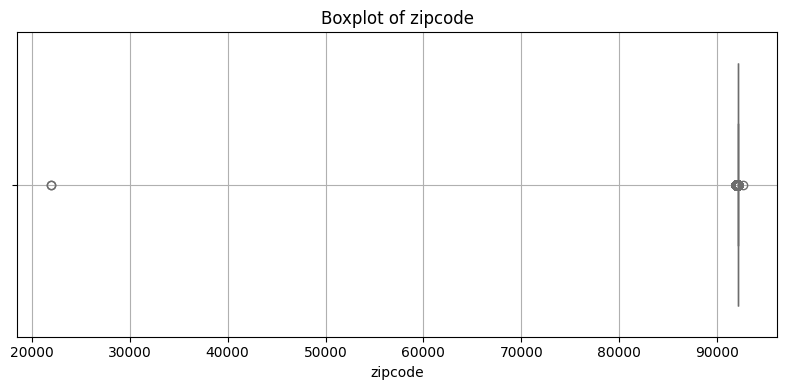

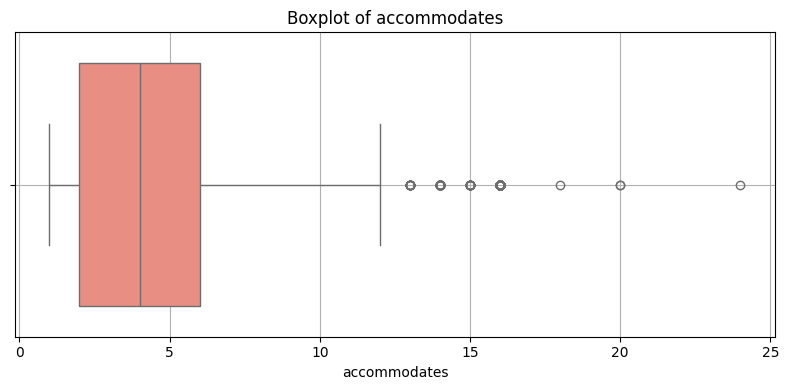

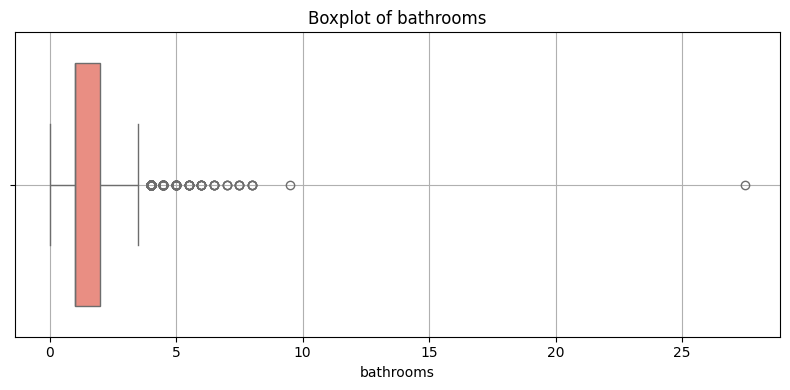

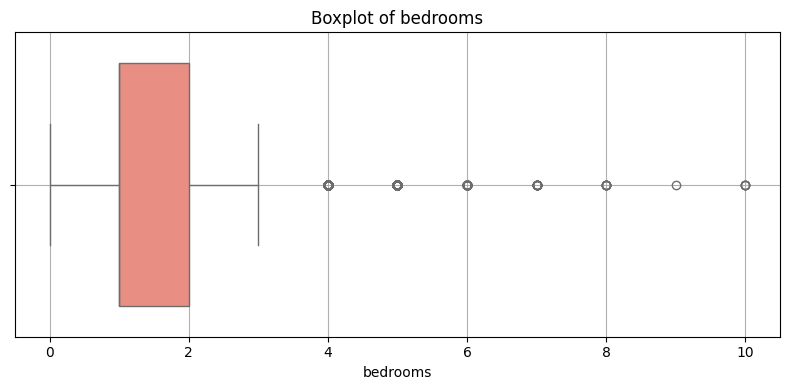

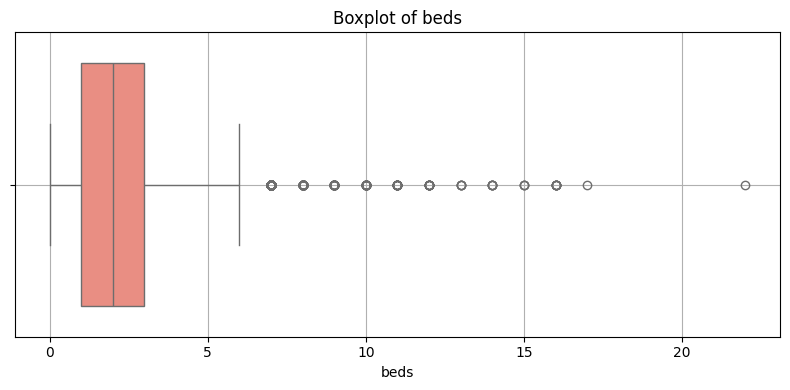

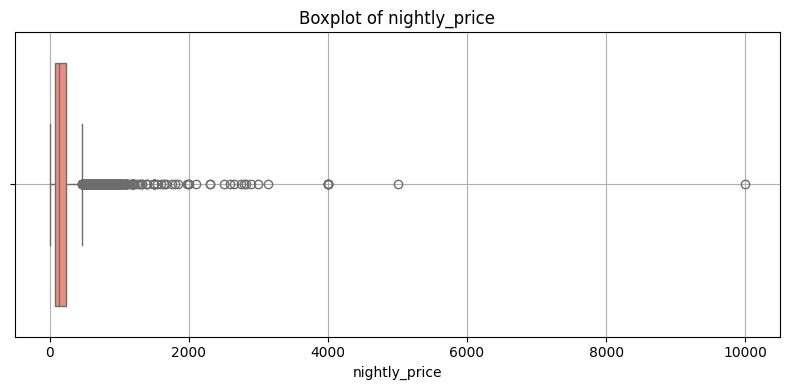

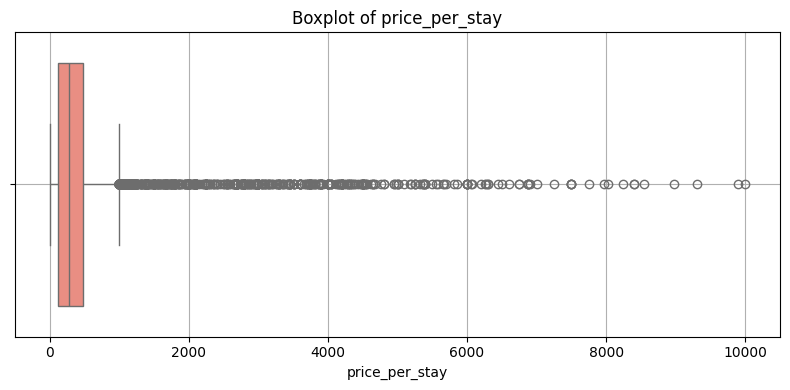

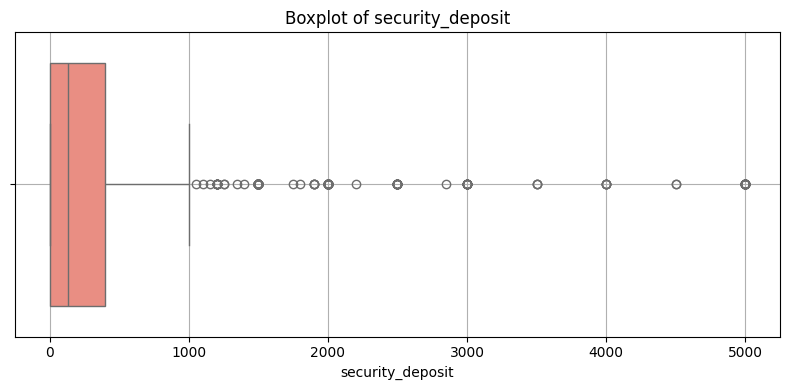

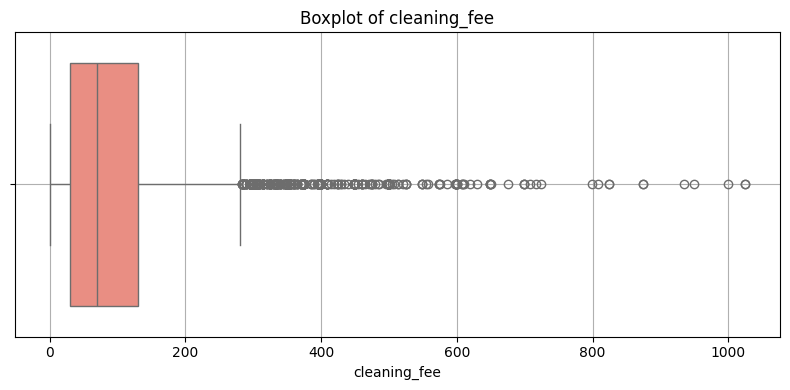

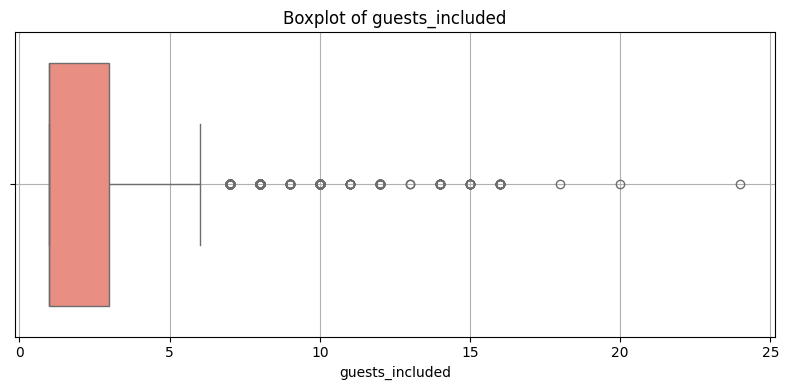

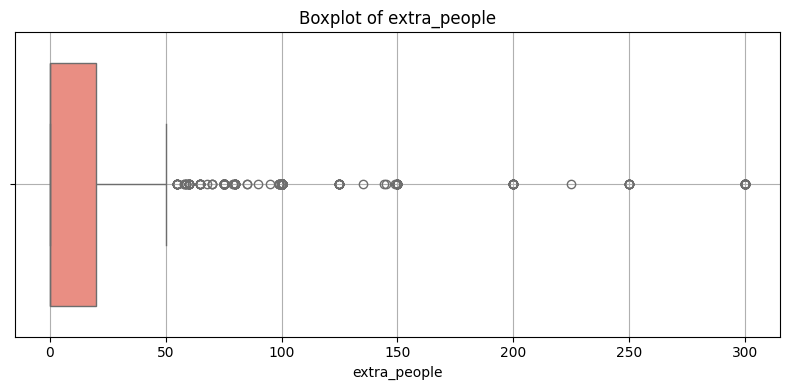

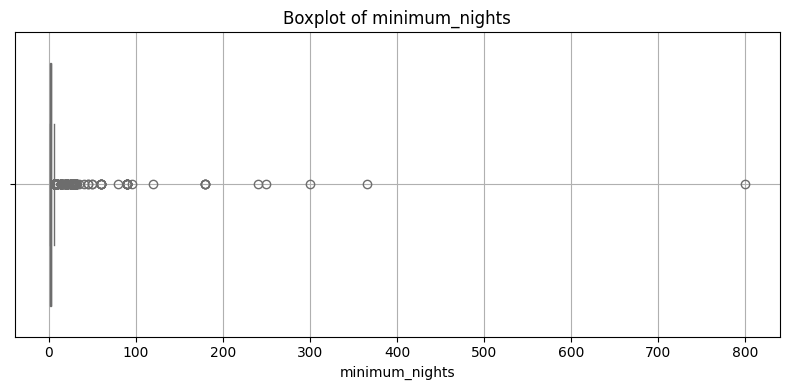

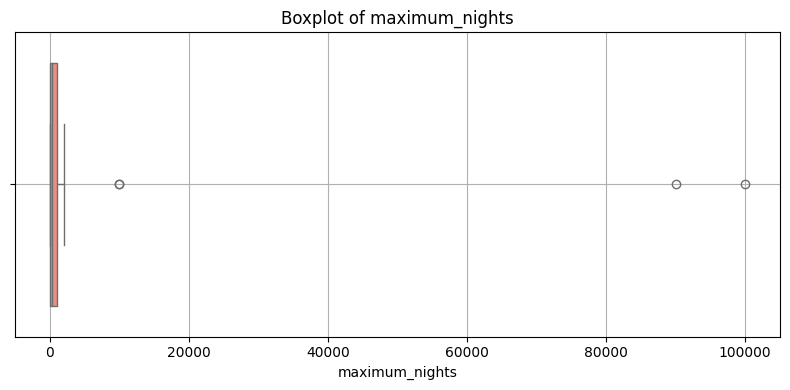

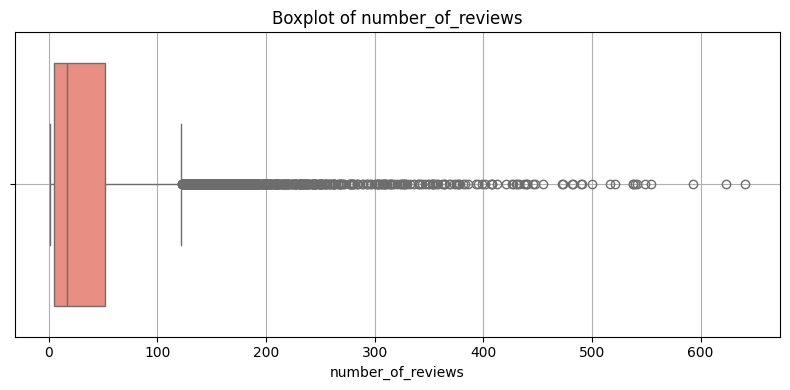

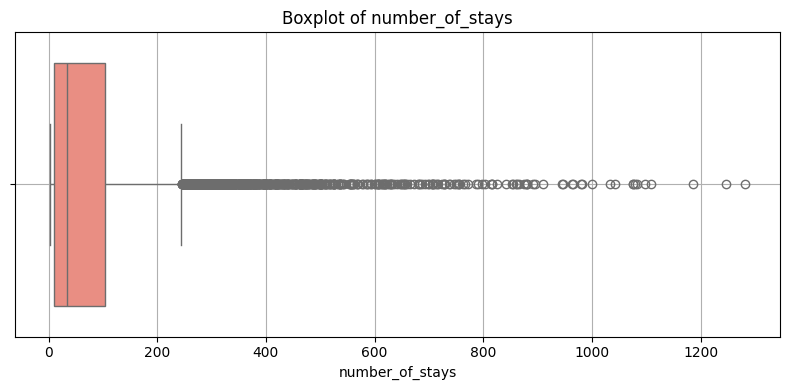

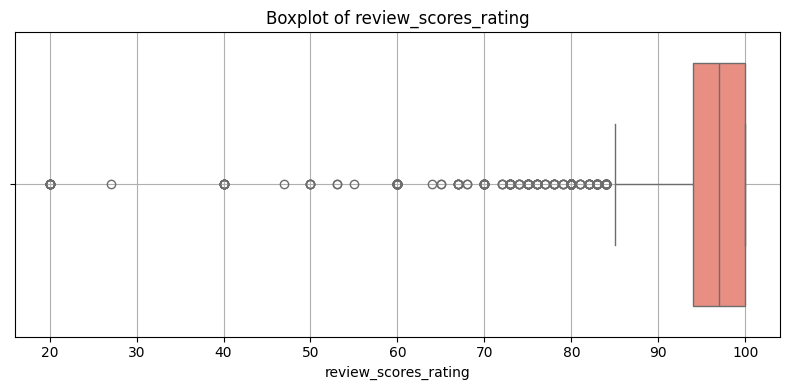

In [242]:
def plot_boxplots(df, numerical_cols):
    for col in numerical_cols:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col], color='salmon')
        plt.title(f"Boxplot of {col}")
        plt.xlabel(col)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

plot_boxplots(df, Numerical_cols)

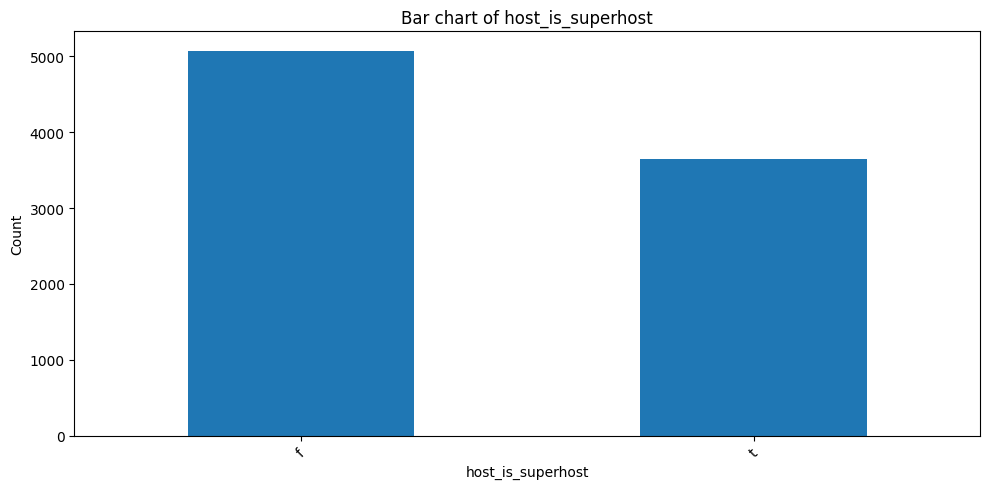

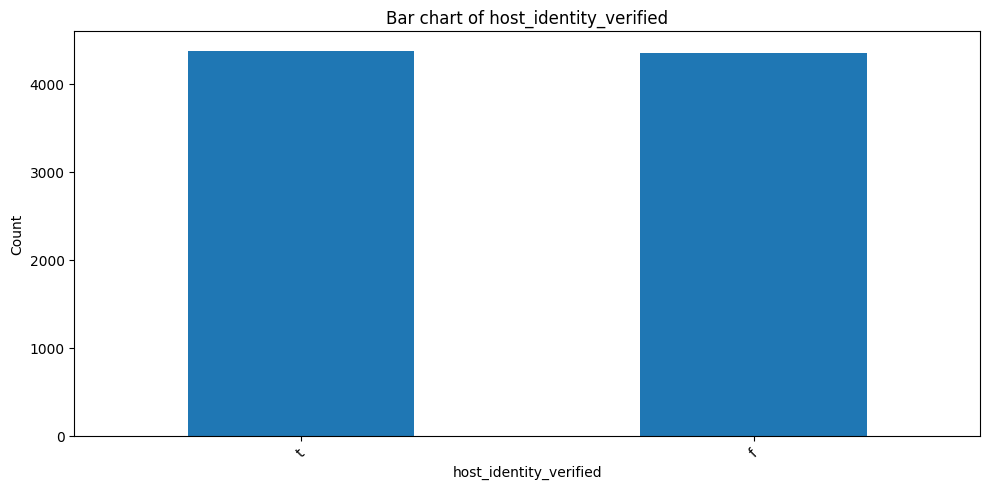

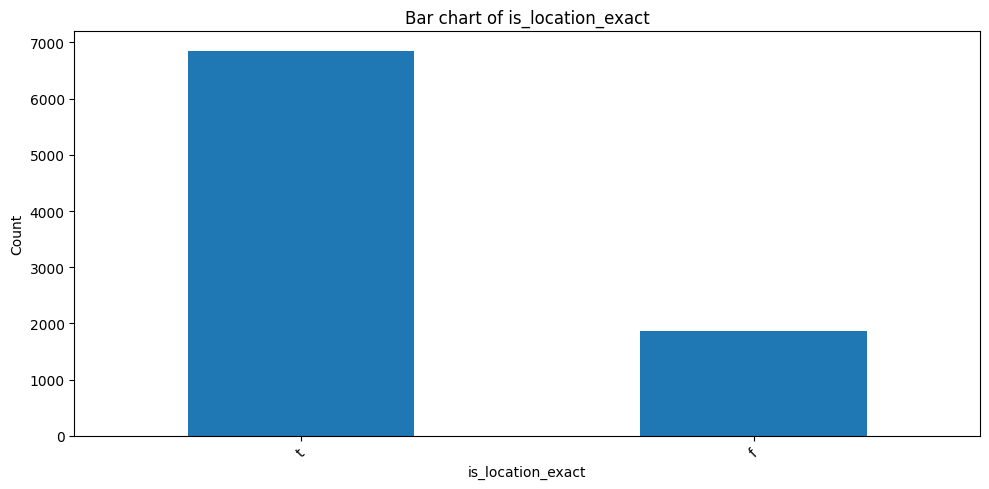

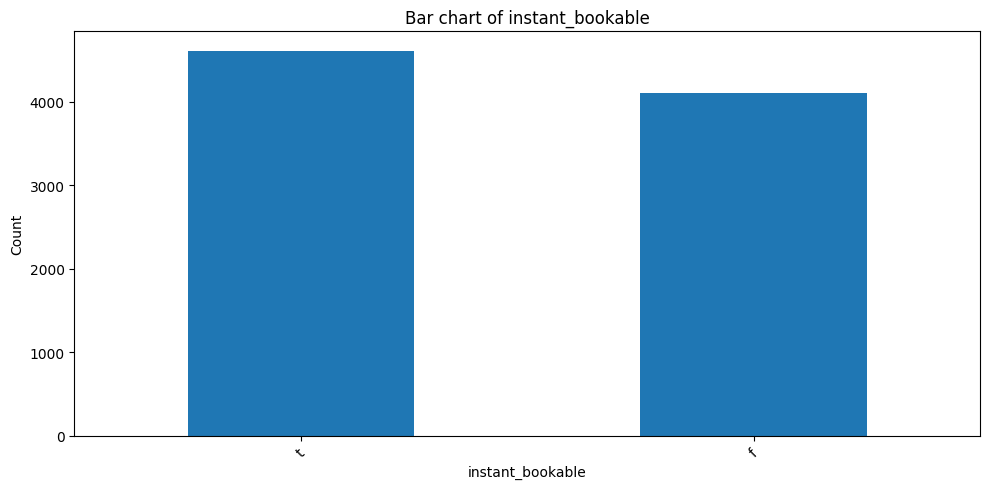

In [243]:
def plot_feature_vs_target(df, categorical_cols, target='review_scores_rating'):
    for col in categorical_cols:
        if col in df.columns:
            if df[col].nunique() > 0:
                plt.figure(figsize=(10, 5))
                df[col].value_counts().head(10).plot(kind='bar')  # top 10 categories
                plt.title(f'Bar chart of {col}')
                plt.xlabel(col)
                plt.ylabel('Count')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Skipping '{col}' due to no unique values to plot.")
        else:
            print(f"Column '{col}' not found in the DataFrame.")

plot_feature_vs_target(df, Categorical_cols)

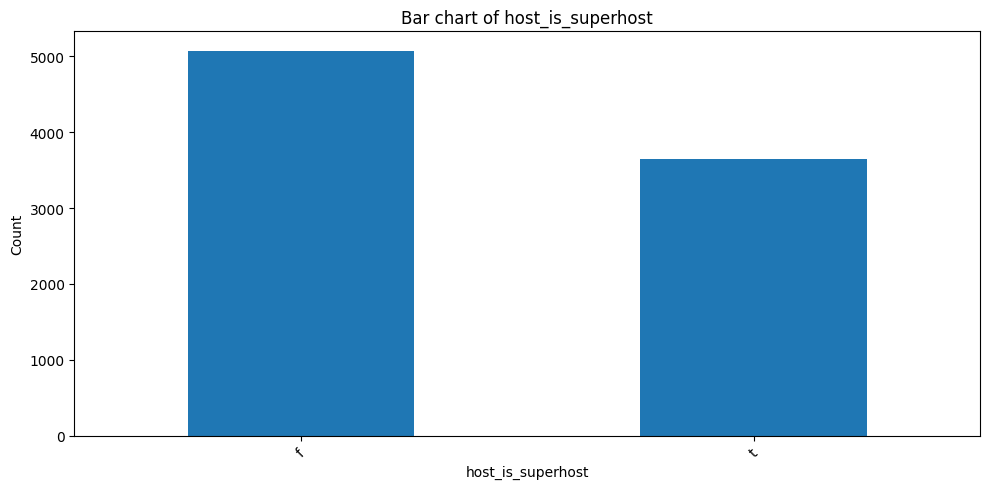

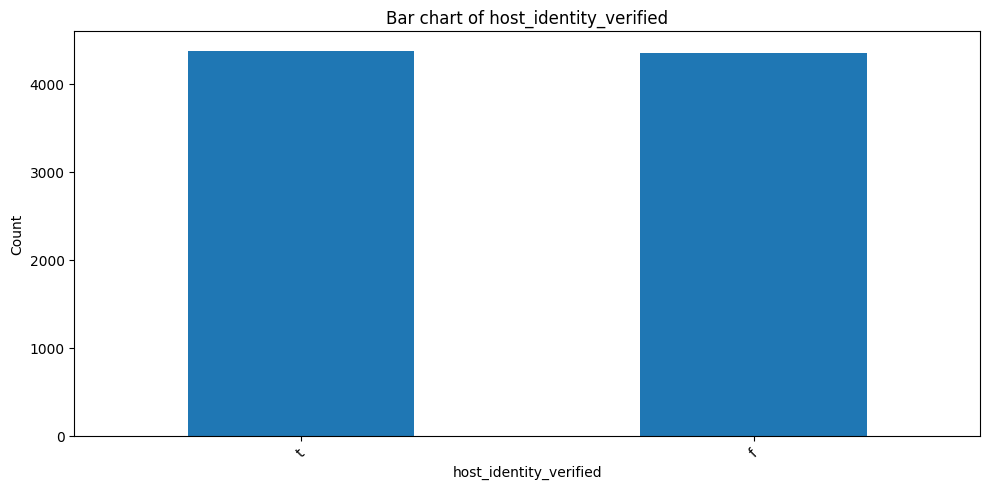

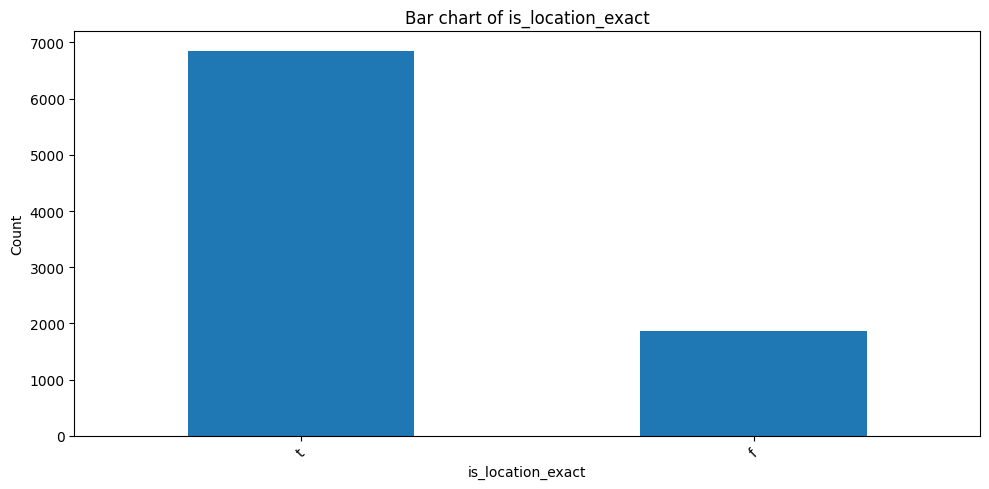

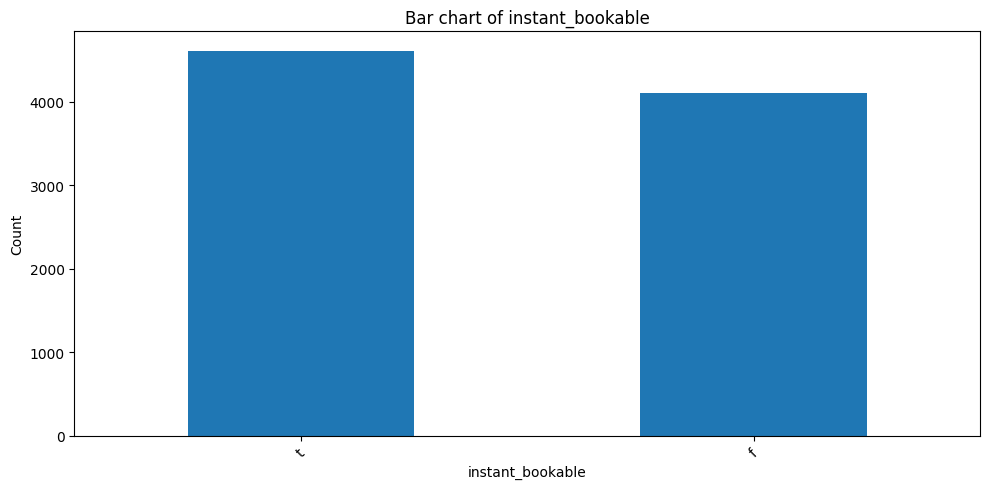

In [244]:
for col in Categorical_cols:
    # Check if the column has any unique values
    if df[col].nunique() > 0:
        plt.figure(figsize=(10, 5))
        df[col].value_counts().head(10).plot(kind='bar')  # top 10 categories
        plt.title(f'Bar chart of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping '{col}' due to no unique values to plot.")

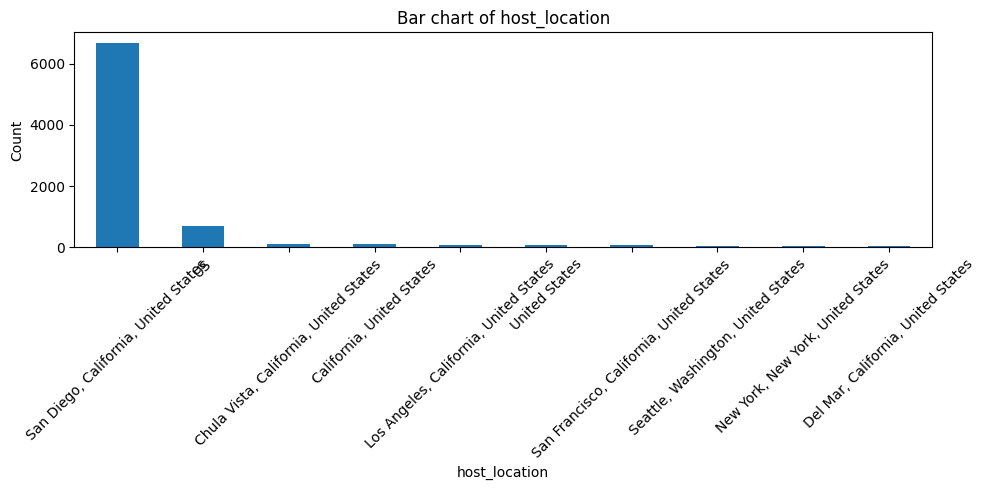

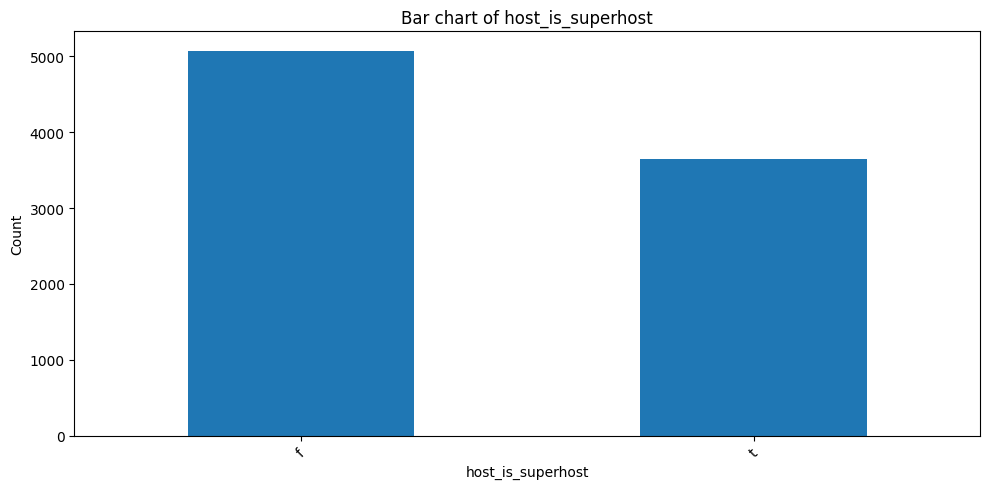

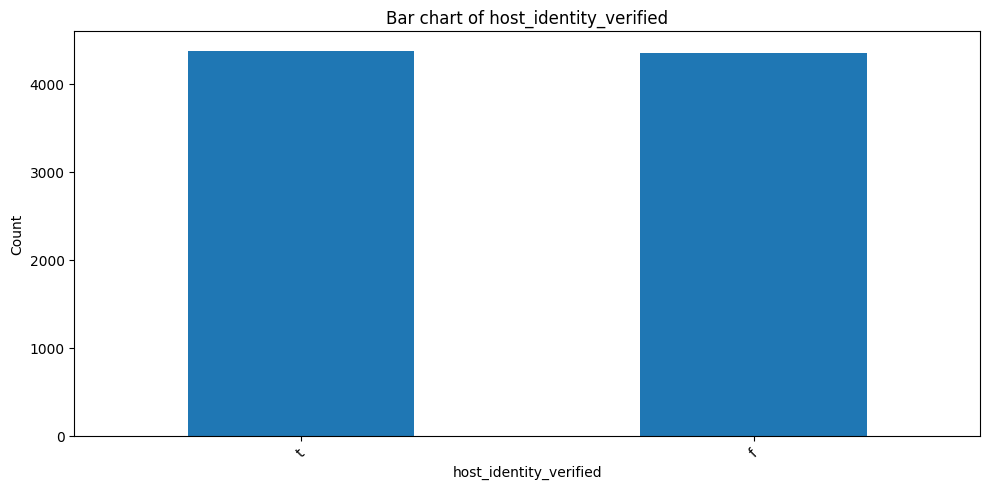

In [245]:
def plot_feature_vs_target(df, numerical_cols, target='review_scores_rating'):
   for col in categorical_cols:
    if df[col].nunique() > 0:
        plt.figure(figsize=(10, 5))
        df[col].value_counts().head(10).plot(kind='bar')  # top 10 categories
        plt.title(f'Bar chart of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping '{col}' due to no unique values to plot.")

plot_feature_vs_target(df, Numerical_cols)

# **Handling outliers**

In [246]:
def handle_outliers_iqr(df, numerical_cols, method='cap'):
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        if method == 'remove':
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        elif method == 'cap':
            df[col] = np.where(df[col] < lower_bound, lower_bound,
                      np.where(df[col] > upper_bound, upper_bound, df[col]))
    return df

In [247]:
df = handle_outliers_iqr(df, Numerical_cols, method='cap')

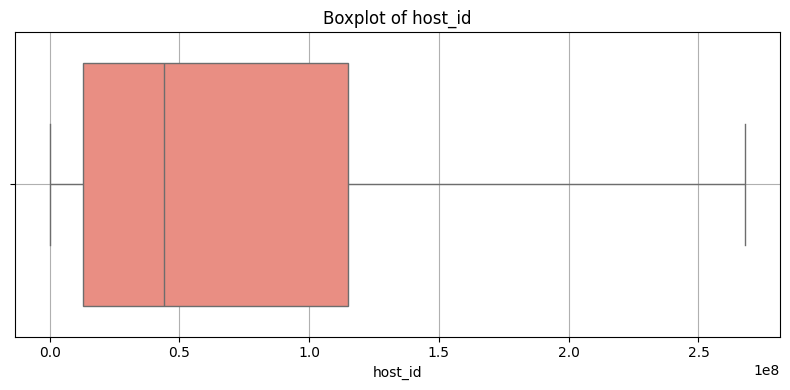

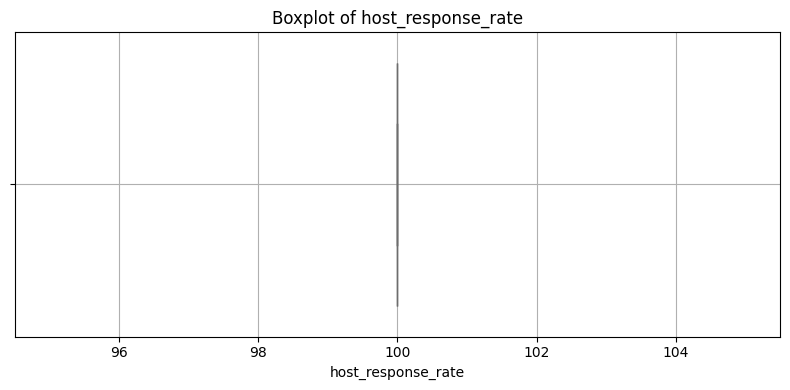

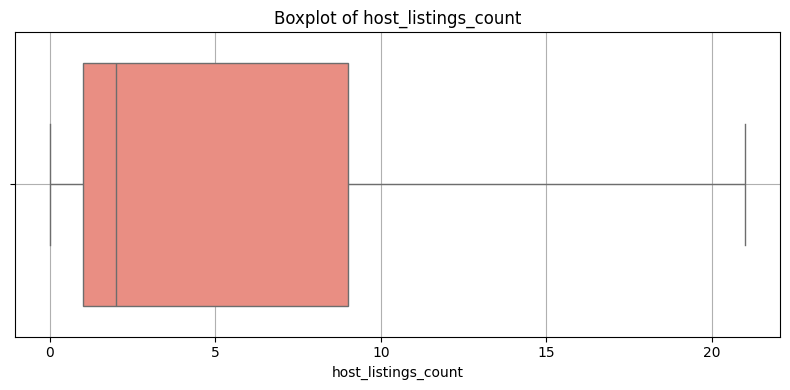

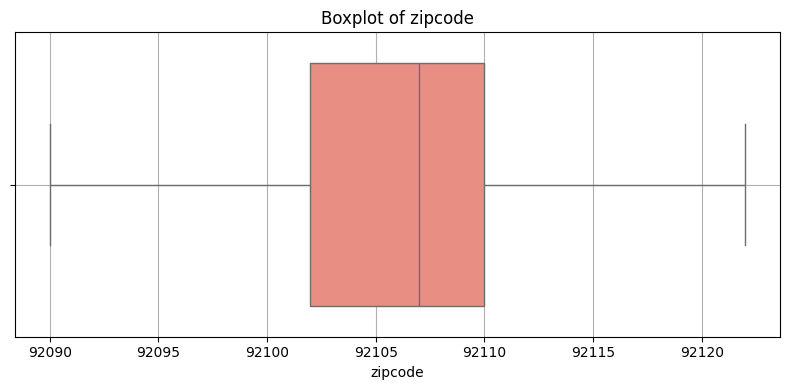

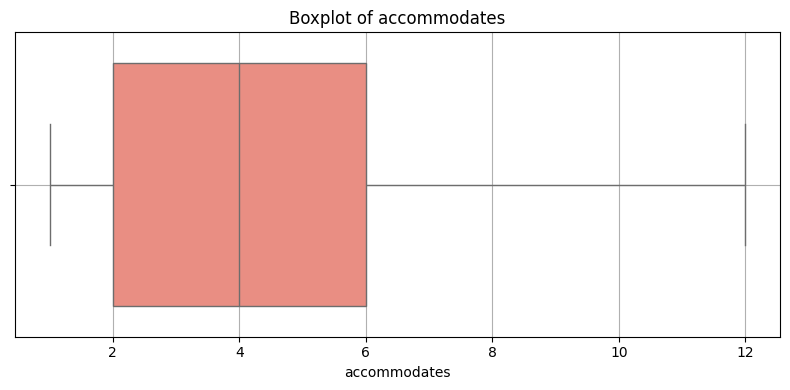

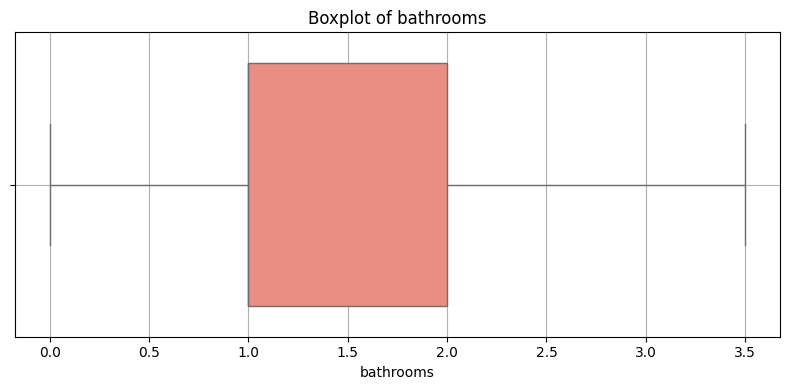

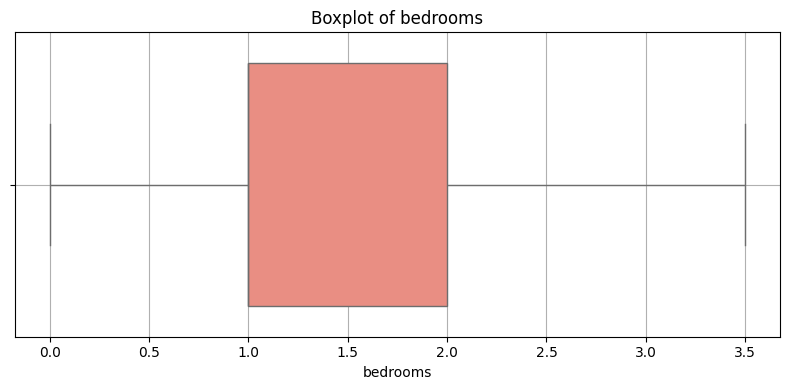

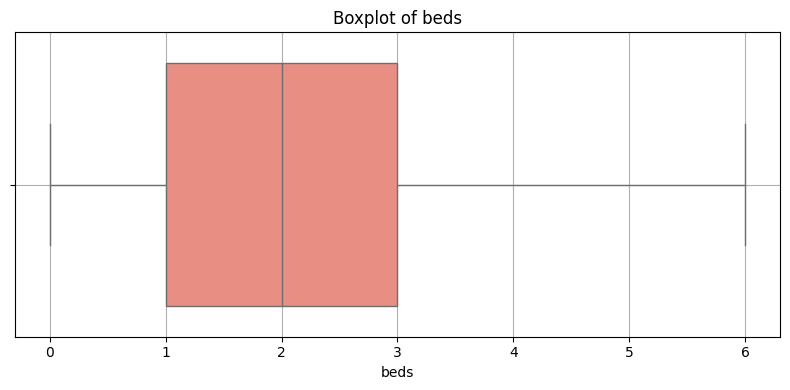

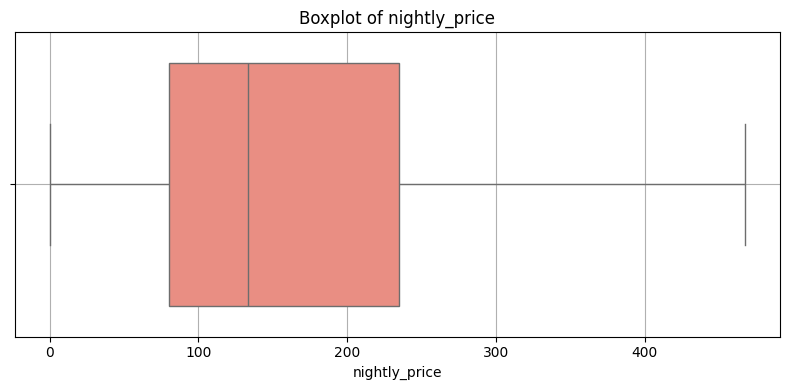

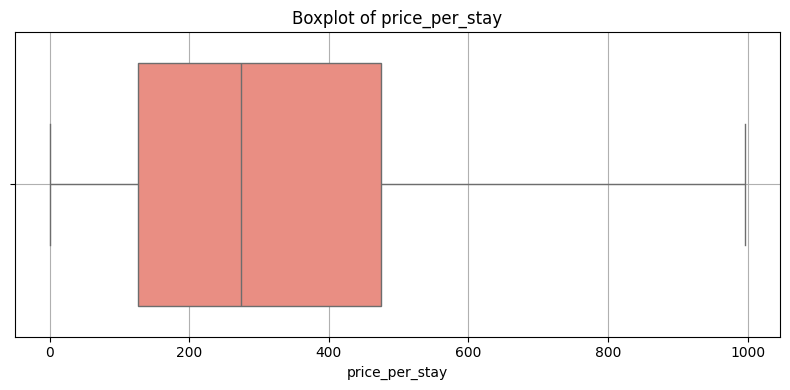

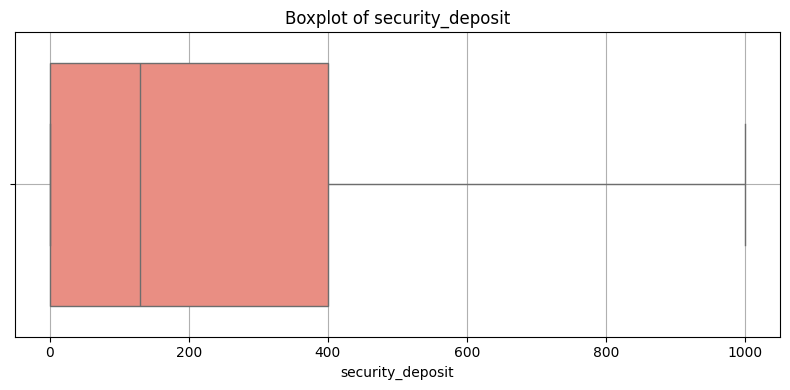

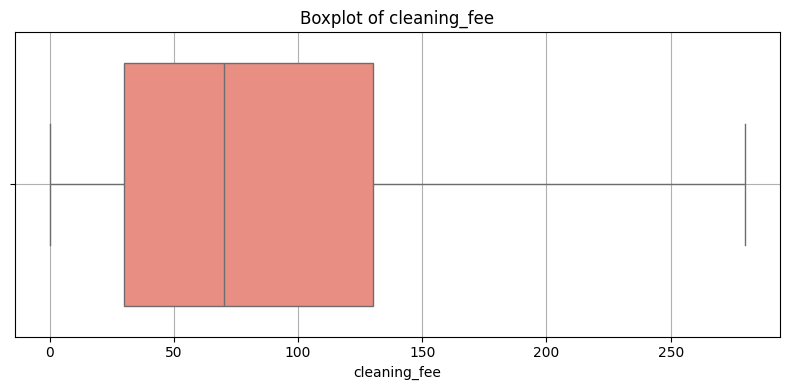

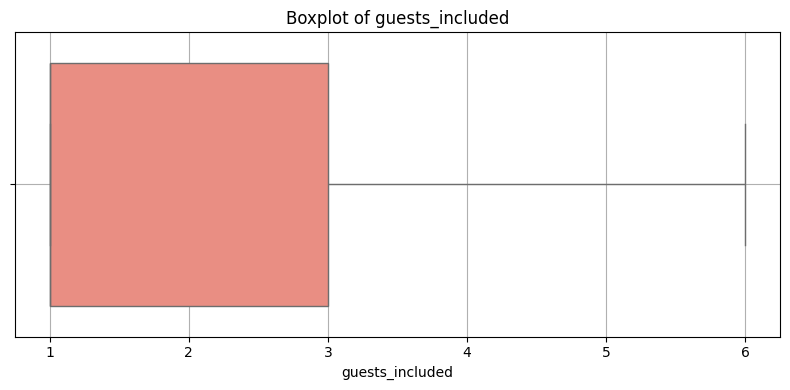

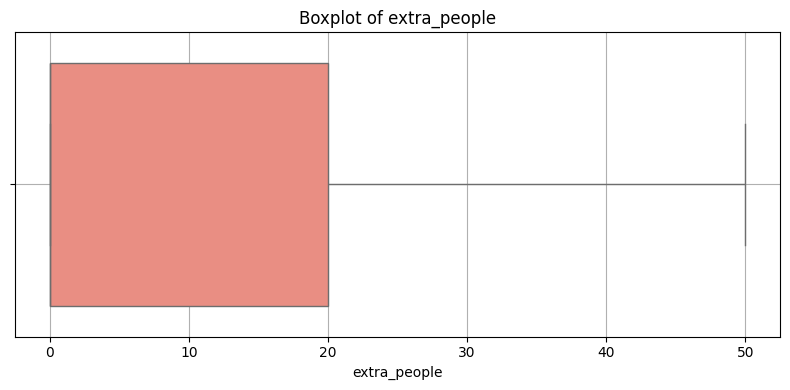

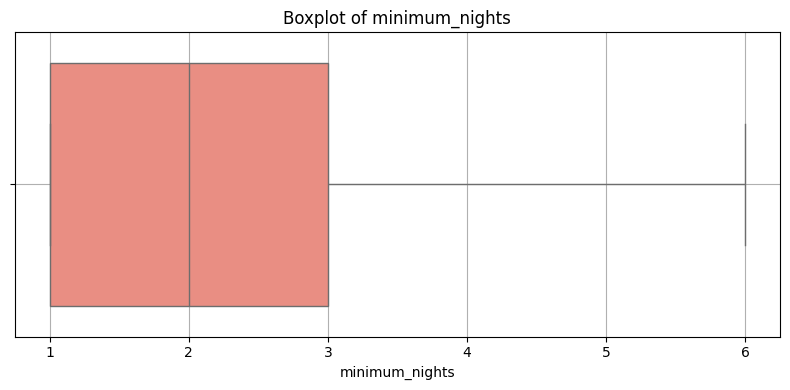

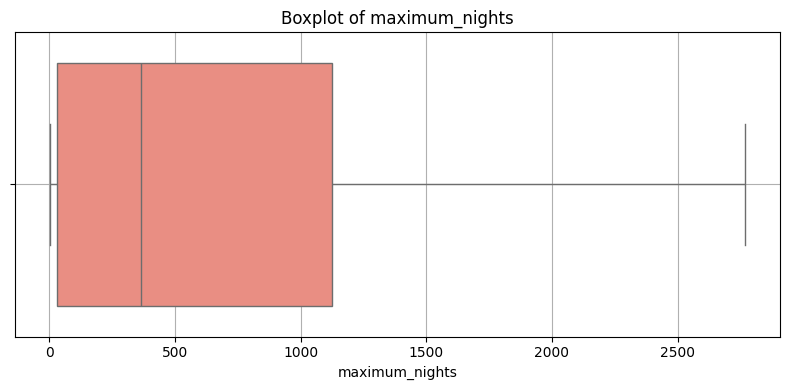

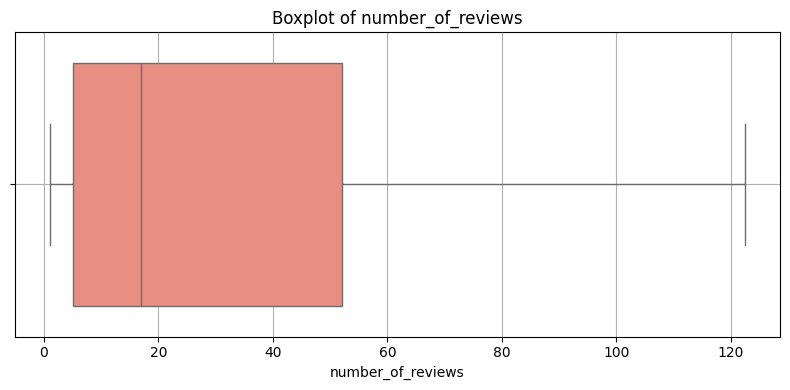

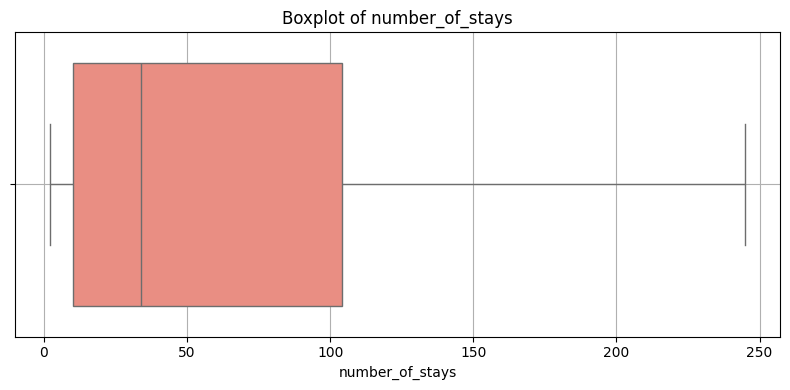

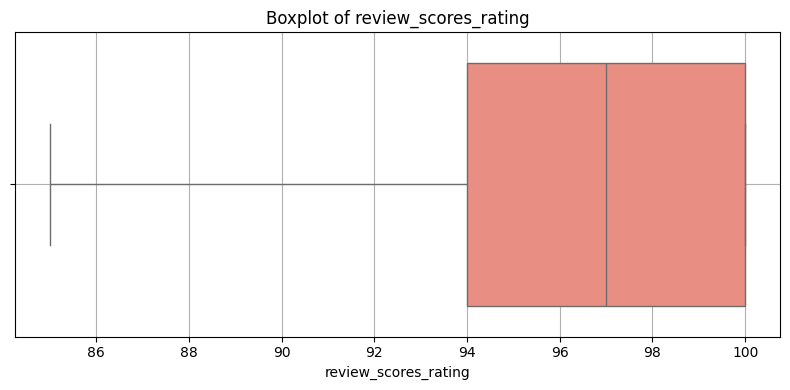

In [248]:
plot_boxplots(df, Numerical_cols)

# **Text Analysis & Preprocessing**

In [249]:
def parse_amenities(amenities_str):
    amenities_str = amenities_str.strip('{}')
    items = [item.strip().strip('"') for item in amenities_str.split(',')]
    return items

df['amenities_parsed'] = df['amenities'].apply(parse_amenities)

amenity_categories = {
    'Basic Necessities': {'Heating', 'Hot water', 'Smoke detector', 'Carbon monoxide detector'},
    'Comfort/Convenience': {'Air conditioning', 'Kitchen', 'Iron', 'Laptop friendly workspace', 'Essentials', 'Hangers'},
    'Technology': {'TV', 'Wifi'},
    'Safety': {'Smoke detector', 'Carbon monoxide detector', 'Lock on bedroom door'},
    'Recreation': {'Pool', 'Gym', 'Hot tub'},
    'Parking': {'Free parking on premises'},
    'Accessibility': {'Elevator', 'Private entrance'}
}

def categorize_amenities(amenities_list):
    categorized = {category: [] for category in amenity_categories}
    for amenity in amenities_list:
        for category, items in amenity_categories.items():
            if amenity in items:
                categorized[category].append(amenity)
    return categorized

df['amenities_categorized'] = df['amenities_parsed'].apply(categorize_amenities)


def create_binary_features(amenities_list):
    binary_features = {}
    all_amenities = set(amenities_list)
    for category, items in amenity_categories.items():
        for item in items:
            binary_features[f'has_{item.lower().replace(" ", "_")}'] = 1 if item in all_amenities else 0
    return binary_features

binary_features_df = df['amenities_parsed'].apply(create_binary_features).apply(pd.Series)


df = df.join(binary_features_df)

df = df.drop(columns=[col for col in ['amenities', 'amenities_parsed', 'amenities_categorized'] if col in df.columns])

print(df.columns)

Index(['description', 'neighborhood_overview', 'notes', 'transit', 'access',
       'interaction', 'house_rules', 'host_id', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_identity_verified', 'neighbourhood_cleansed', 'zipcode',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'nightly_price', 'price_per_stay',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'number_of_stays', 'first_review', 'last_review',
       'review_scores_rating', 'instant_bookable', 'cancellation_policy',
       'has_heating', 'has_carbon_monoxide_detector', 'has_hot_water',
       'has_smoke_detector', 'has_iron', 'has_laptop_friendly_workspace',
       'has_kitchen', 'has_air_conditioning', 'has_essentials', 'has_

In [250]:
def get_text_columns(df, sample_ratio=0.3, min_avg_len=5, min_unique=3):
    text_columns = []

    for col in df.columns:
        sample = df[col].dropna().sample(frac=min(sample_ratio, 1.0), random_state=42)

        is_text = sample.apply(lambda x: isinstance(x, str) and not x.isnumeric()).mean() > 0.8
        avg_len = sample.apply(lambda x: len(x) if isinstance(x, str) else 0).mean()
        num_unique = df[col].nunique()

        if is_text and avg_len > min_avg_len and num_unique >= min_unique:
            text_columns.append(col)

    return text_columns


text_columns = get_text_columns(df)
print("Text columns in the DataFrame:", text_columns)

Text columns in the DataFrame: ['description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'host_location', 'host_about', 'host_response_time', 'host_neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type', 'cancellation_policy']


In [251]:
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))

    # tokenize with 'english' language
    tokens = word_tokenize(text, language='english')
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)
preprocessed_columns = [f"{col}_cleaned" for col in text_columns]
for col in text_columns:
    df[f"{col}_cleaned"] = df[col].apply(preprocess_text)

text_columns.remove('host_response_time')
df = df.drop(columns=text_columns)
df.columns


Index(['host_id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'zipcode', 'is_location_exact', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'nightly_price', 'price_per_stay', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'number_of_stays',
       'first_review', 'last_review', 'review_scores_rating',
       'instant_bookable', 'has_heating', 'has_carbon_monoxide_detector',
       'has_hot_water', 'has_smoke_detector', 'has_iron',
       'has_laptop_friendly_workspace', 'has_kitchen', 'has_air_conditioning',
       'has_essentials', 'has_hangers', 'has_wifi', 'has_tv',
       'has_lock_on_bedroom_door', 'has_gym', 'has_pool', 'has_hot_tub',
       'has_free_parking_on_premises', 'has_private_entrance', 'has_elevator',
       'description_cleaned', 'neighborhood_overview_cleaned', 'notes

In [252]:
def calculate_text_importance(df, text_columns, target_col, max_features=1000):
    importance_scores = {}

    for col in text_columns:
        vectorizer = TfidfVectorizer(max_features=max_features)
        try:
            tfidf = vectorizer.fit_transform(df[col].astype(str))
        except ValueError:
            df[col] = 0.0
            importance_scores[col] = 0.0
            continue

        doc_variances = np.array(tfidf.todense()).var(axis=1).flatten()
        df[col] = doc_variances

        term_variances = np.array(tfidf.todense()).var(axis=0).mean()

        correlations = []
        for i in range(tfidf.shape[1]):
            term_scores = tfidf[:, i].toarray().flatten()
            with np.errstate(invalid='ignore'):
                corr, _ = spearmanr(term_scores, df[target_col].values)
            correlations.append(abs(corr))

        avg_corr = np.nanmean(correlations) if correlations else 0.0

        importance = (term_variances + avg_corr) / 2
        importance_scores[col] = importance

    return importance_scores

importance_scores = calculate_text_importance(df, preprocessed_columns, target_col='review_scores_rating', max_features=1000)
print("Importance Scores:", importance_scores)

Importance Scores: {'description_cleaned': np.float64(0.008284694852623268), 'neighborhood_overview_cleaned': np.float64(0.008041002426727803), 'notes_cleaned': np.float64(0.008501115614400678), 'transit_cleaned': np.float64(0.007044751590363718), 'access_cleaned': np.float64(0.00731833198811183), 'interaction_cleaned': np.float64(0.007652238625721967), 'house_rules_cleaned': np.float64(0.012970457716579962), 'host_location_cleaned': np.float64(0.006192850189603226), 'host_about_cleaned': np.float64(0.010128483753474533), 'host_response_time_cleaned': np.float64(0.03131049797138388), 'host_neighbourhood_cleaned': np.float64(0.00976865945581418), 'neighbourhood_cleansed_cleaned': np.float64(0.011120922270053069), 'property_type_cleaned': np.float64(0.017664003341602307), 'room_type_cleaned': np.float64(0.0766420281442351), 'cancellation_policy_cleaned': np.float64(0.09208417819542031)}


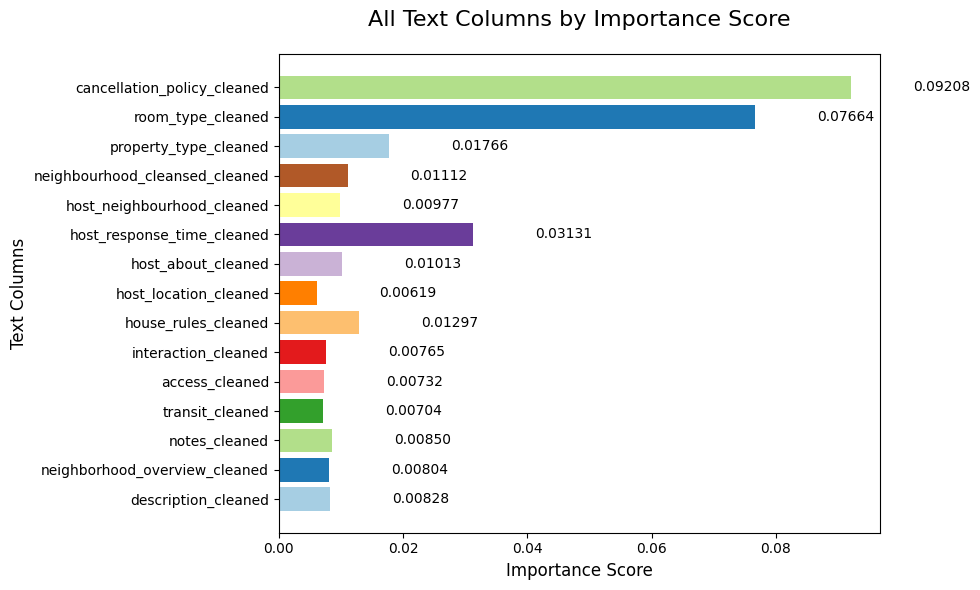

In [253]:
def visualize(importance_scores):

    fig, ax = plt.subplots(figsize=(10, 6))

    columns = list(importance_scores.keys())
    values = list(importance_scores.values())

    bars = ax.barh(columns, values, color=plt.cm.Paired.colors)
    ax.set_title("All Text Columns by Importance Score", fontsize=16, pad=20)
    ax.set_xlabel("Importance Score", fontsize=12)
    ax.set_ylabel("Text Columns", fontsize=12)
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01,bar.get_y() + bar.get_height() / 2,f"{width:.5f}",ha='left',va='center',fontsize=10)

    plt.tight_layout()
    plt.show()


visualize(importance_scores)

In [254]:
df['host_location_cleaned'] = df['host_location_cleaned'].astype(str)

# Exact match
target_location = 'San Diego, California, United States'
match_mask = df['host_location_cleaned'].str.strip() == target_location

# Calculate percentage
percentage = match_mask.mean() * 100

print(f"Percentage of entries that are exactly '{target_location}': {percentage:.2f}%")

Percentage of entries that are exactly 'San Diego, California, United States': 0.00%


# **Feature Engineering**

In [255]:
df['review_duration_days'] = (df['last_review'] - df['first_review']).dt.days
df['review_duration_months'] = df['review_duration_days'] / 30
zero_month_count = (df['review_duration_months'] == 0).sum()
total_rows = len(df)
percentage_zero_months = (zero_month_count / total_rows) * 100

print(f"Percentage of zero-month durations: {percentage_zero_months:.2f}%") #hnemla al 8% dool b eh??
print(df[['first_review', 'last_review', 'review_duration_months', 'review_duration_days']].head())
print(df['review_duration_months'].max())
print(df['review_duration_days'].max())


Percentage of zero-month durations: 7.77%
  first_review last_review  review_duration_months  review_duration_days
0   2017-11-17  2017-11-17                0.000000                     0
1   2013-08-02  2019-07-31               72.966667                  2189
2   2017-07-23  2019-07-16               24.100000                   723
3   2018-05-01  2019-08-03               15.300000                   459
4   2019-06-30  2019-06-30                0.000000                     0
129.53333333333333
3886


In [256]:
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
df['host_duration_days'] = (pd.to_datetime("today") - df['host_since']).dt.days
df['host_duration_months'] = df['host_duration_days'] / 30
df['host_duration_years'] = df['host_duration_days'] / 365.25
print(df[['host_since', 'host_duration_days', 'host_duration_months', 'host_duration_years']].head())
print(df['host_duration_days'].max())
print(df['host_duration_months'].max())
print(df['host_duration_years'].max())
#7asa al years ansab 7aga

  host_since  host_duration_days  host_duration_months  host_duration_years
0 2012-10-15              4591.0            153.033333            12.569473
1 2013-01-29              4485.0            149.500000            12.279261
2 2013-11-05              4205.0            140.166667            11.512663
3 2018-04-11              2587.0             86.233333             7.082820
4 2013-08-23              4279.0            142.633333            11.715264
6278.0
209.26666666666668
17.188227241615333


In [257]:
oldest_host_date = df['host_since'].min()
df['host_relative_age_days'] = (df['host_since'] - oldest_host_date).dt.days
df['host_relative_age_months'] = df['host_relative_age_days'] / 30
df['host_relative_age_years'] = df['host_relative_age_days'] / 365.25
print(df[['host_since', 'host_relative_age_days', 'host_relative_age_months', 'host_relative_age_years']].head())
zero_month_count = (df['host_relative_age_days'] == 0).sum()
total_rows = len(df)
percentage_zero_months = (zero_month_count / total_rows) * 100
print(df['host_relative_age_days'].max())
print(df['host_relative_age_months'].max())
print(df['host_relative_age_years'].max())
print(f"Percentage of zero-month durations relative host: {percentage_zero_months:.2f}%")#percentage msh kbeera f eshta
#years ansab 7aga bardoo

  host_since  host_relative_age_days  host_relative_age_months  \
0 2012-10-15                  1687.0                 56.233333   
1 2013-01-29                  1793.0                 59.766667   
2 2013-11-05                  2073.0                 69.100000   
3 2018-04-11                  3691.0                123.033333   
4 2013-08-23                  1999.0                 66.633333   

   host_relative_age_years  
0                 4.618754  
1                 4.908966  
2                 5.675565  
3                10.105407  
4                 5.472964  
4176.0
139.2
11.433264887063656
Percentage of zero-month durations relative host: 0.01%


In [258]:
drop_columns = ['first_review',
                'last_review','host_since']
df.drop(columns=drop_columns, inplace=True)

In [259]:
# Host Features
df['host_response_power'] = df['host_response_rate'] * np.log1p(df['host_listings_count'])
df['host_commitment'] = df['host_duration_days'] / (df['number_of_stays'] + 1)

In [260]:
# Property Quality Indicators
df['bedroom_quality'] = df['bedrooms'] / (df['bathrooms'] + 0.5)
df['space_per_guest'] = df['accommodates'] / (df['beds'] + 0.1)

In [261]:
#Features related to time
df['seasonal_demand'] = np.sin(2 * np.pi * (df['host_duration_days'] % 365) / 365)
df['recent_review_boost'] = np.where(df['review_duration_days'] < 30, 1, 0.5)

In [262]:
#Amenity Combinations
df['essential_amenities'] = df[['has_wifi', 'has_air_conditioning', 'has_kitchen']].sum(axis=1)
df['luxury_amenities'] = df[['has_hot_tub', 'has_pool', 'has_gym']].sum(axis=1)

In [263]:
#features based on guest reviews
df['review_consistency'] = df['number_of_reviews'] / (df['review_scores_rating'] + 1)
df['positive_momentum'] = df['review_scores_rating'] * np.log1p(df['number_of_reviews'])

In [264]:
# Feature to evaluate value for money
df['price_value'] = df['nightly_price'] / df['accommodates']

# **Encoding**

In [265]:
df = df.replace({
    'require_guest_phone_verification': {'t': 1, 'f': 0},
    'require_guest_profile_picture': {'t': 1, 'f': 0},
    'instant_bookable': {'t': 1, 'f': 0},
    'is_location_exact': {'t': 1, 'f': 0},
    'host_identity_verified': {'t': 1, 'f': 0},
    'host_has_profile_pic': {'t': 1, 'f': 0},
    'is_business_travel_ready': {'t': 1, 'f': 0},
    'host_is_superhost': {'t': 1, 'f': 0},
    'requires_license': {'t': 1, 'f': 0}
})


<ipython-input-265-97ab60c984c8>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({


In [266]:
label_cols = [
    'cancellation_policy_cleaned', 'room_type_cleaned', 'property_type_cleaned',
]

# Apply LabelEncoder to each column
le = LabelEncoder()

for col in label_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [267]:
mapping = {
    'within an hour': 1,
    'within a few hours': 2,
    'within a day': 3,
    'a few days or more': 4
}

df['host_response_time'] = df['host_response_time'].map(mapping)

# **Feature Selection**

---

Numerical Selection

---


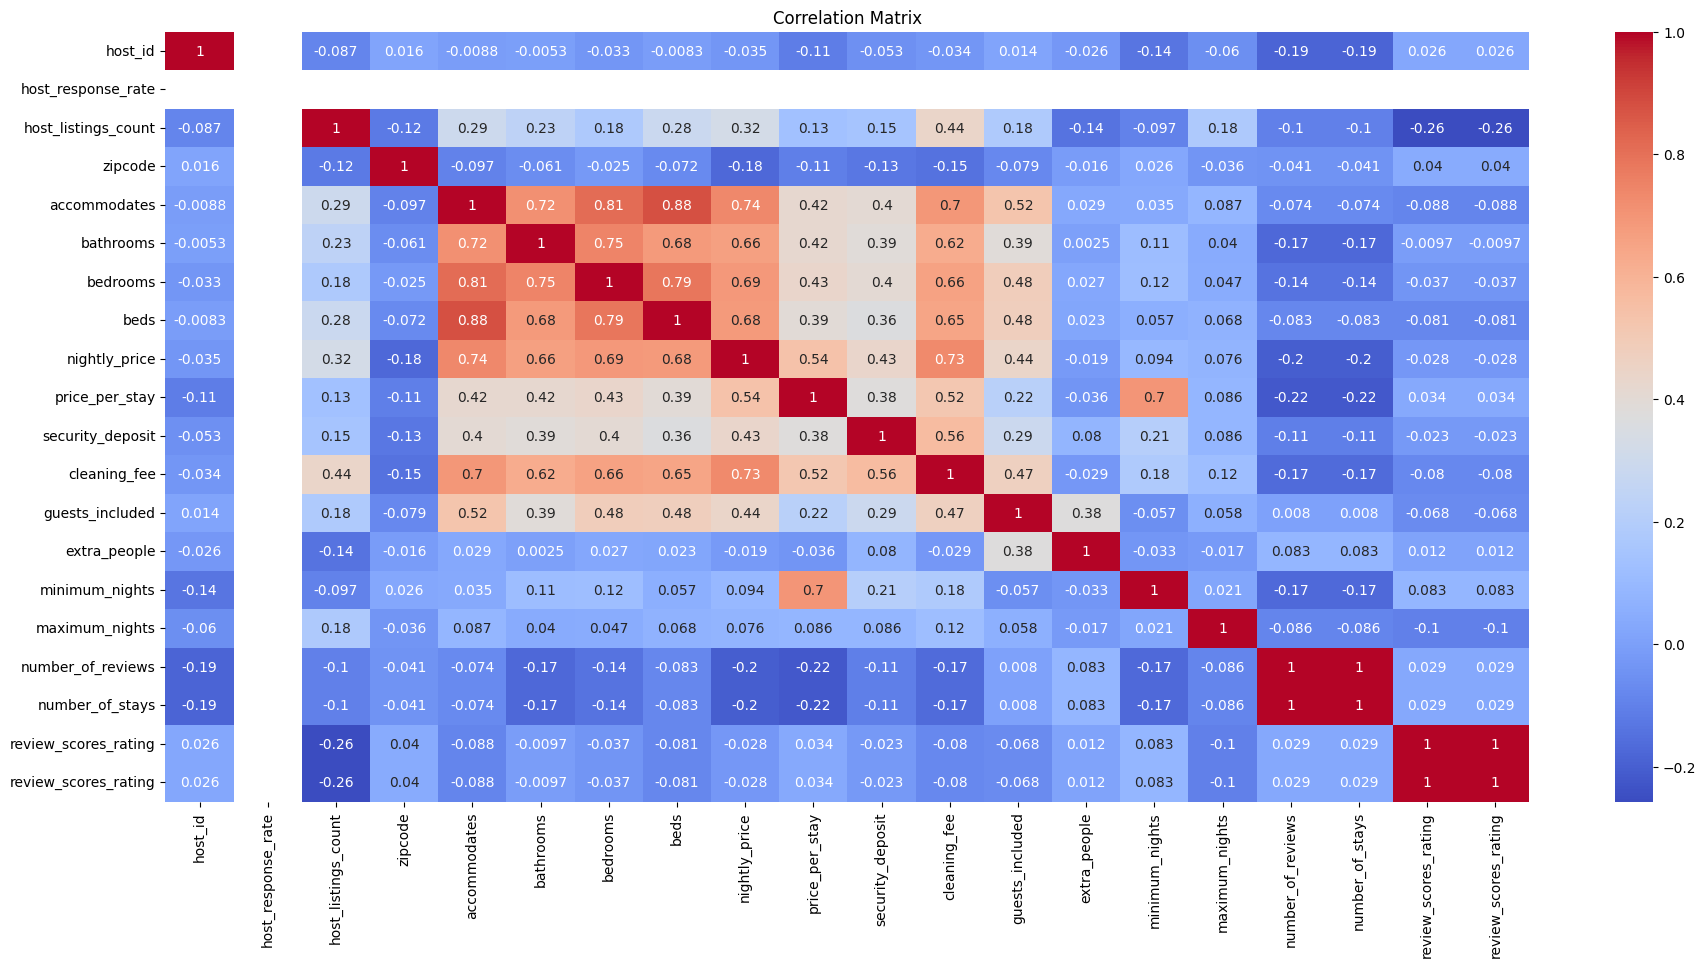

In [268]:
#Heat map for numerical values that can be easily read (law ntb3 al corr badl m nt7wel yb2a foll aw)
selected_cols = Numerical_cols + ['review_scores_rating']
corr_matrix = df[selected_cols].corr()

# Plot heatmap
plt.figure(figsize=(22, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()



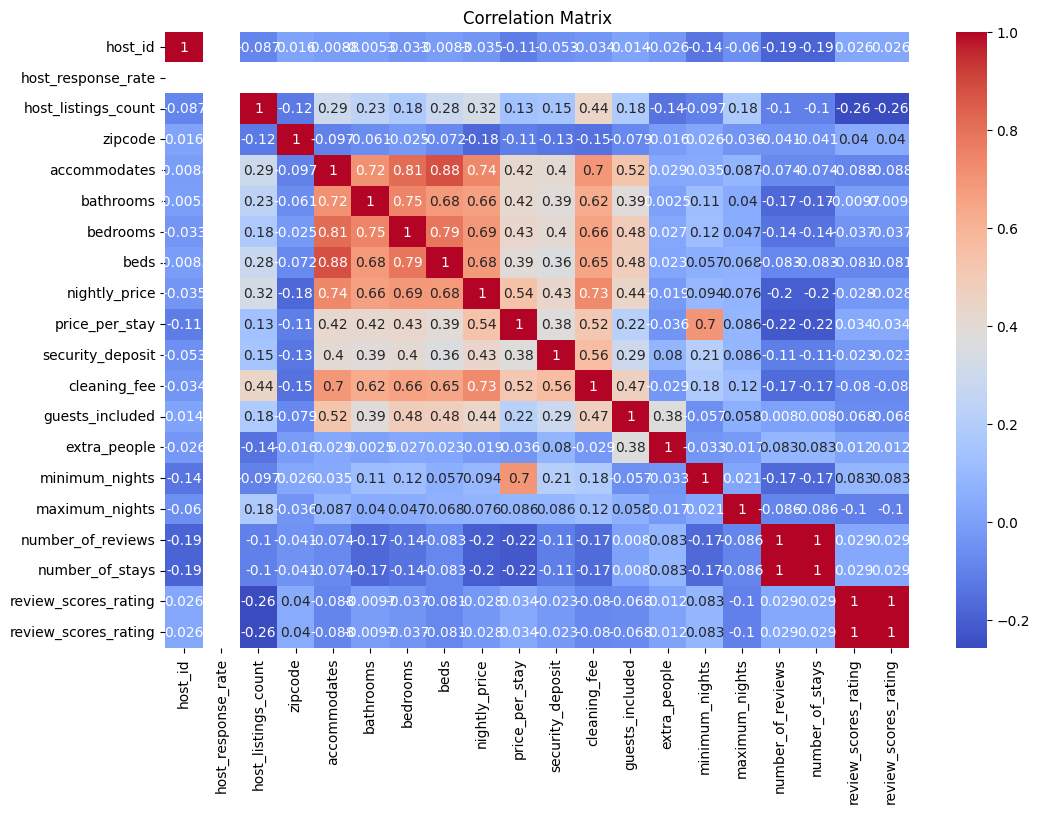

In [269]:
selected_cols = Numerical_cols + ['review_scores_rating']
corr_matrix = df[selected_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Selected Top 10 Features:
- host_id
- host_listings_count
- zipcode
- nightly_price
- cleaning_fee
- guests_included
- minimum_nights
- number_of_reviews
- number_of_stays
- review_scores_rating


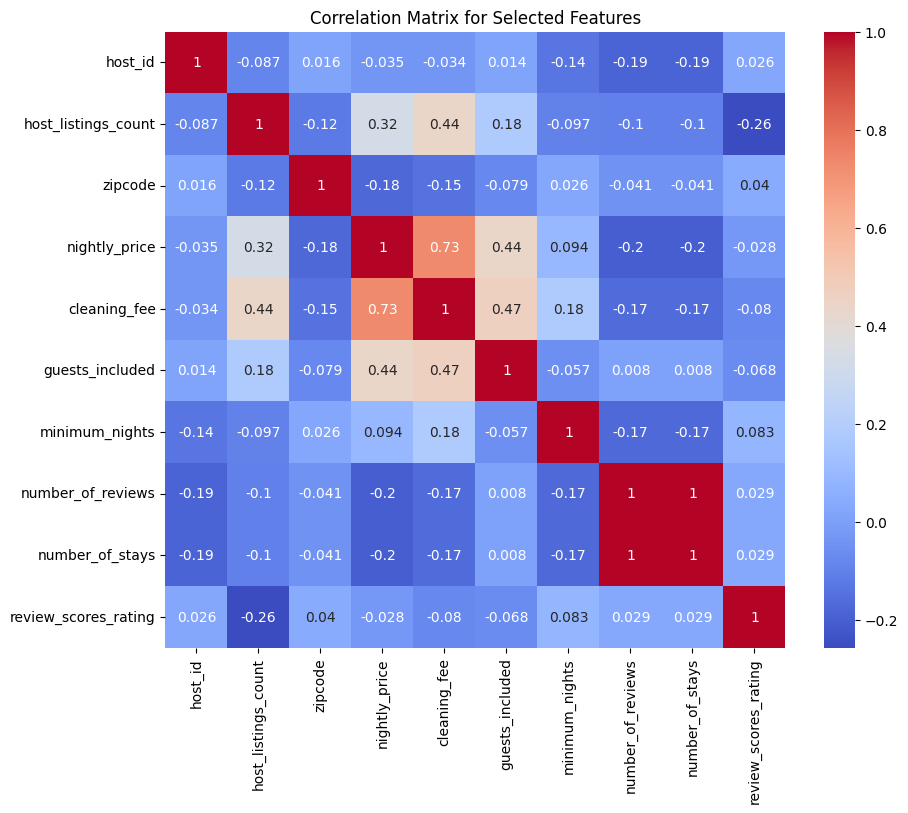

In [270]:
from sklearn.feature_selection import mutual_info_regression
#Fill missing values in numerical columns
imputer = KNNImputer(n_neighbors=5)
df[Numerical_cols] = imputer.fit_transform(df[Numerical_cols])

#Feature Selection
X = df[Numerical_cols]
y = df['review_scores_rating']

# Apply SelectKBest with mutual_info_regression
selector = SelectKBest(score_func=mutual_info_regression, k=10)
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Top 10 Features:")
for feature in selected_features:
    print("-", feature)

# Plot Heatmap for selected features
corr_matrix_selected = df[selected_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_selected, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Selected Features')
plt.show()


In [271]:
#from the previous heat map we have selected coulmns with corr > 0.1
selected_coulmns = ['host_listings_count', 'accommodates', 'beds', 'cleaning_fee', 'minimum_nights', 'maximum_nights','review_scores_rating']

#make a new df with selected features
listing_features_df = df[selected_coulmns].copy()
print(listing_features_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8724 entries, 0 to 8723
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_listings_count   8724 non-null   float64
 1   accommodates          8724 non-null   float64
 2   beds                  8724 non-null   float64
 3   cleaning_fee          8724 non-null   float64
 4   minimum_nights        8724 non-null   float64
 5   maximum_nights        8724 non-null   float64
 6   review_scores_rating  8724 non-null   float64
dtypes: float64(7)
memory usage: 477.2 KB
None


---

Categorical Selection

---

In [272]:
object_cols = df.select_dtypes(include='object')
print(f"🧾 Number of object columns: {object_cols.shape[1]}")

🧾 Number of object columns: 1


In [273]:
target_col = 'review_scores_rating'

# Identify text columns from the dataframe
text_cols = df.select_dtypes(include='object').columns.tolist()
text_cols = [col for col in text_cols if df[col].notnull().sum() > 0]
df[text_cols] = df[text_cols].fillna("")

In [274]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_texts = []
feature_source = []

for col in text_cols:
    try:
        X_col = vectorizer.fit_transform(df[col].astype(str))
        if X_col.shape[1] == 0:
            continue
        X_texts.append(X_col)
        features = vectorizer.get_feature_names_out()
        feature_source.extend([col for _ in features])
    except ValueError:
        continue

X_combined = hstack(X_texts)

In [275]:
# Encode target column if it's categorical
y = df[target_col]
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)

In [276]:
# Feature selection using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=100)
X_selected = selector.fit_transform(X_combined, y)

# Analyze selected features
selected_mask = selector.get_support()
scores = selector.scores_
pvalues = selector.pvalues_

In [277]:
feature_info = pd.DataFrame({'source_column': feature_source,'score': scores[:len(feature_source)],'p_value': pvalues[:len(feature_source)],'selected': selected_mask[:len(feature_source)]}).sort_values(by='score', ascending=False)

# Aggregate statistics by source column
source_stats = feature_info.groupby('source_column').agg({'score': ['mean', 'max', 'count'],'selected': 'sum'}).sort_values(by=('selected', 'sum'), ascending=False)

top_avg_score = feature_info.groupby('source_column')['score'].mean().sort_values(ascending=False).head(20)
bottom_avg_score = feature_info.groupby('source_column')['score'].mean().sort_values(ascending=True).head(20)

In [278]:
# Output results
print("\nTop Source Columns Contributing the Most Selected Features:")
print("These columns have the highest number of features that were deemed important by the model.")
print(source_stats.head(20).to_string())

print("\nTop 20 Source Columns Ranked by Average Importance (F-score):")
print("These columns contain features that scored the highest on average in terms of predictive power.")
print(top_avg_score.to_string())


Top Source Columns Contributing the Most Selected Features:
These columns have the highest number of features that were deemed important by the model.
                          score                 selected
                           mean       max count      sum
source_column                                           
host_location_cleaned  1.046257  6.098086   229      100

Top 20 Source Columns Ranked by Average Importance (F-score):
These columns contain features that scored the highest on average in terms of predictive power.
source_column
host_location_cleaned    1.046257



 Final List of Selected Features and Their Importance Scores:
These are the most impactful features chosen by the model, along with their importance scores:
                 feature     score
0  host_location_cleaned  1.855531


<ipython-input-279-b889775a5db3>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='score', y='source_column', palette='viridis')


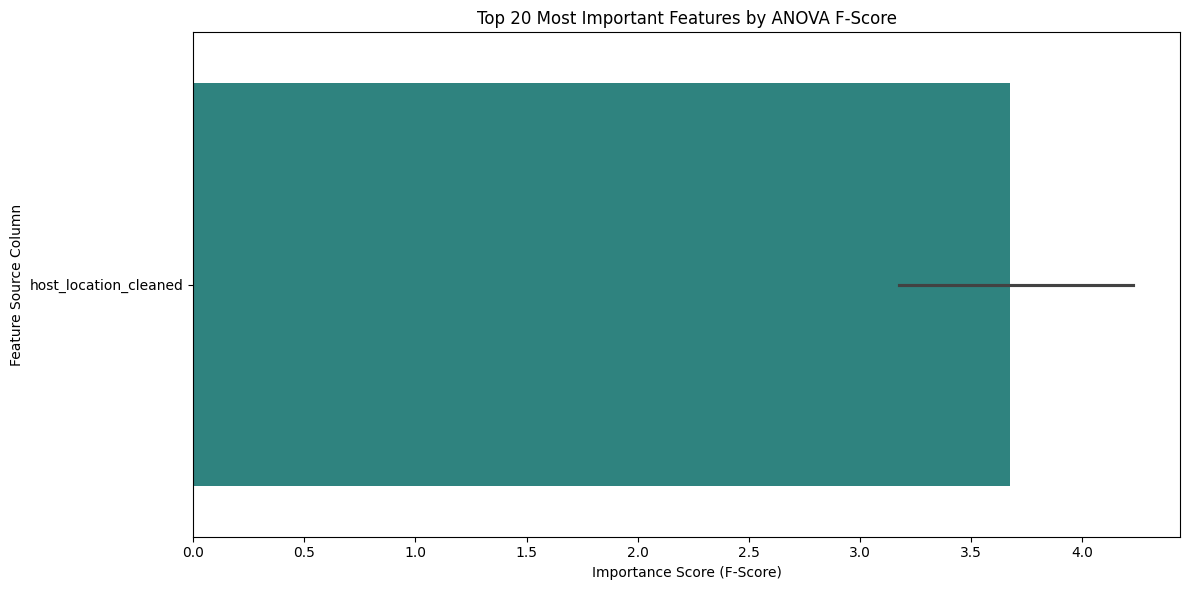

In [279]:
selected_scores = scores[selected_mask]
selected_feature_names = [feature_source[i] for i in range(len(feature_source)) if selected_mask[i]]

# Remove duplicates from selected feature names
unique_selected_feature_names = list(set(selected_feature_names))

# Create a DataFrame for visualization
selected_features_df = pd.DataFrame({'feature': unique_selected_feature_names, 'score': selected_scores[:len(unique_selected_feature_names)]}).sort_values(by='score', ascending=False)

print("\n Final List of Selected Features and Their Importance Scores:")
print("These are the most impactful features chosen by the model, along with their importance scores:")
print(selected_features_df)

# Visualize
top_features = feature_info.head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_features, x='score', y='source_column', palette='viridis')
plt.title('Top 20 Most Important Features by ANOVA F-Score')
plt.xlabel('Importance Score (F-Score)')
plt.ylabel('Feature Source Column')
plt.tight_layout()
plt.show()

In [280]:
# Results from Anova
best_text_columns = [ "host_about_cleaned","house_rules_cleaned","notes_cleaned","cancellation_policy_cleaned","description_cleaned","interaction_cleaned", "access_cleaned","room_type_cleaned","property_type_cleaned","host_response_time"]
Cat_features_df = df[best_text_columns].copy()
listing_features_df = pd.concat([listing_features_df, Cat_features_df], axis=1)

# Take the Data

In [281]:
listing_features_df = listing_features_df.to_csv("Features1.csv")

In [282]:
df = df.to_csv("Cleaned_data.csv")